<a href="https://colab.research.google.com/github/maengg/Customer_churn/blob/main/Customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **데이터 설명**

*데이터 셋은 kaggle의 [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) 데이터셋으로 3분기에 캘리포니아의 7043명의 고객에게 집 전화 및 인터넷 서비스를 제공한 가상의 통신 회사에 대한 정보를 담고 있다. <br>
(데이터의 형태는 7043 rows, 21 columns)*

<br>

### **각 column 설명**

* gender : 고객의 성별
* SeniorCitizen : 고객이 65세 이상인지 아닌지 (Yes : 1, No : 0)
* Dependents : 고객이 부양가족과 함께 살고 있는지, 부양가족은 자녀, 부모, 조부모 등이 될 수 있다. (Yes , No)
* Partner : 결혼 여부(Yes ,No)
* tenure : 누적 이용 기간 (단위 : 월)
* PhoneService : 고객이 집 전화 서비스에 구독했는지 여부 (Yes ,No)
* MultipleLines : 고객이 여러 전화선에 구독했는지 여부 (Yes, No, No phone service)
* InternetService : 고객이 인터넷 서비스에 구독했는지 여부 (No, DSL, Fiber optic)
* OnlineSecurity : 고객이 온라인 보안 서비스에 구독했는지 여부 (Yes, No, No internet service)
* OnlineBackup : 고객이 온라인 백업 서비스를 구독했는지 여부 (Yes, No, No internet service)
* DeviceProtection : 고객이 추가 장치 보호 요금제에 가입했는지 여부 (Yes, No, No internet service)
* TechSupport : 고객이 줄어든 대기시간으로 추가 기술 지원 요금제에 가입했는지 여부 (Yes, No, No internet service)
* StreamingTV : 고객이 TV 스트리밍을 이용하는지 여부 (Yes, No, No internet service) 
* StreamingMovies : 고객이 영화 스트리밍을 이용하는지 여부 (Yes, No, No internet service)
* Contract : 고객의 현재 계약 유형 (Month-to-month(월간), One year(1년), Two year(2년))
* PaperlessBilling : 고객이 전자명세서를 선택했는지 (Yes, No)
* PaymentMethod : 고객이 청구서를 지불하는 방법 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* MonthlyCharges : 월별 납부 금액
* TotalCharges : 누적 납부 금액
* Churn : 이탈 여부 (Yes, No), Target data

## **라이브러리 설치 및 데이터 불러오기.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# category_encoder 설치
!pip install category_encoders

     |████████████████████████████████| 86 kB 2.6 MB/s 


In [3]:
# Catboost 설치
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [4]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.7 MB/s 


In [5]:
!pip install --upgrade scipy

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [6]:
# 라이브러리 불러오기.
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
from scipy.stats import randint, uniform, normaltest, kstest
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import eli5
from eli5.sklearn import PermutationImportance

# 시각화 style white로 설정.
sns.set(style = 'white')

# FutureWarning 무시
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# 데이터 불러오기.
df_original = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
# 데이터셋 확인.

print('Data shape :', df_original.shape)
df_original.head()

Data shape : (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
# 원본 데이터 보호를 위해 데이터 copy
df = df_original.copy()
df.shape

(7043, 21)

## **EDA**

In [10]:
# 각 컬럼별 데이터 타입이 알맞은지 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
# TotalCharges의 경우 숫자형 데이터인데 object로 되어있기에, 확인 필요.
# 최빈값이 ' '로 총 11개의 데이터가 공백으로 처리되어 있음을 확인.
df['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

In [12]:
# 공백으로 처리된 데이터 확인.
# tenure가 0이다. 즉, 아직 가입한지 한달이 지나지 않은 고객들
df[df['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [13]:
# TotalCharges 숫자형으로 바꾸고 빈 공백은 결측치로 처리. 즉, 가입한지 한달이 안된 고객은 결측치로 처리.
# 고객 이탈 분석이라는 목적에 가입한지 한달이 안된 고객은 부적절한 데이터라고 판단하여 삭제 후 결측치 확인.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [14]:
# index reset
df.reset_index(drop=True, inplace=True)

In [15]:
# 중복 데이터 확인
print(f'데이터에서 중복 데이터는 총 {df.duplicated().sum()}개 입니다.')

데이터에서 중복 데이터는 총 0개 입니다.


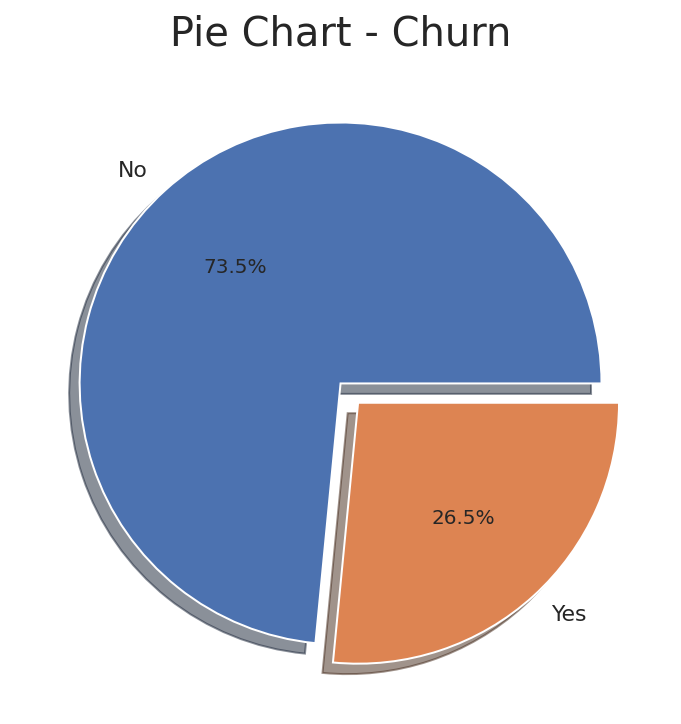

In [16]:
# 타겟 데이터 확인

# pie plot
def pieplot(col, data=df_original):
  plt.figure(figsize=(10,6))
  if len(data[col].unique()) == 2:
    data[col].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True)
    plt.title(f'Pie Chart - {col}', fontsize=20)
    plt.ylabel('')
  elif len(data[col].unique()) == 3:
    data[col].value_counts().plot.pie(explode=[0,0.1,0.1], autopct='%1.1f%%', shadow=True)
    plt.title(f'Pie Chart - {col}', fontsize=20)
    plt.ylabel('')
  else:
    data[col].value_counts().plot.pie(explode=[0,0.1,0.1,0.1], autopct='%1.1f%%', shadow=True)
    plt.title(f'Pie Chart - {col}', fontsize=20)
    plt.ylabel('')

  plt.show()

pieplot('Churn')

In [17]:
# Churn 특성 No => 0, Yes =>1

df['Churn'].replace({'No' : 0, 'Yes' : 1}, inplace=True)

**어느정도 불균형이 있는 걸 확인**

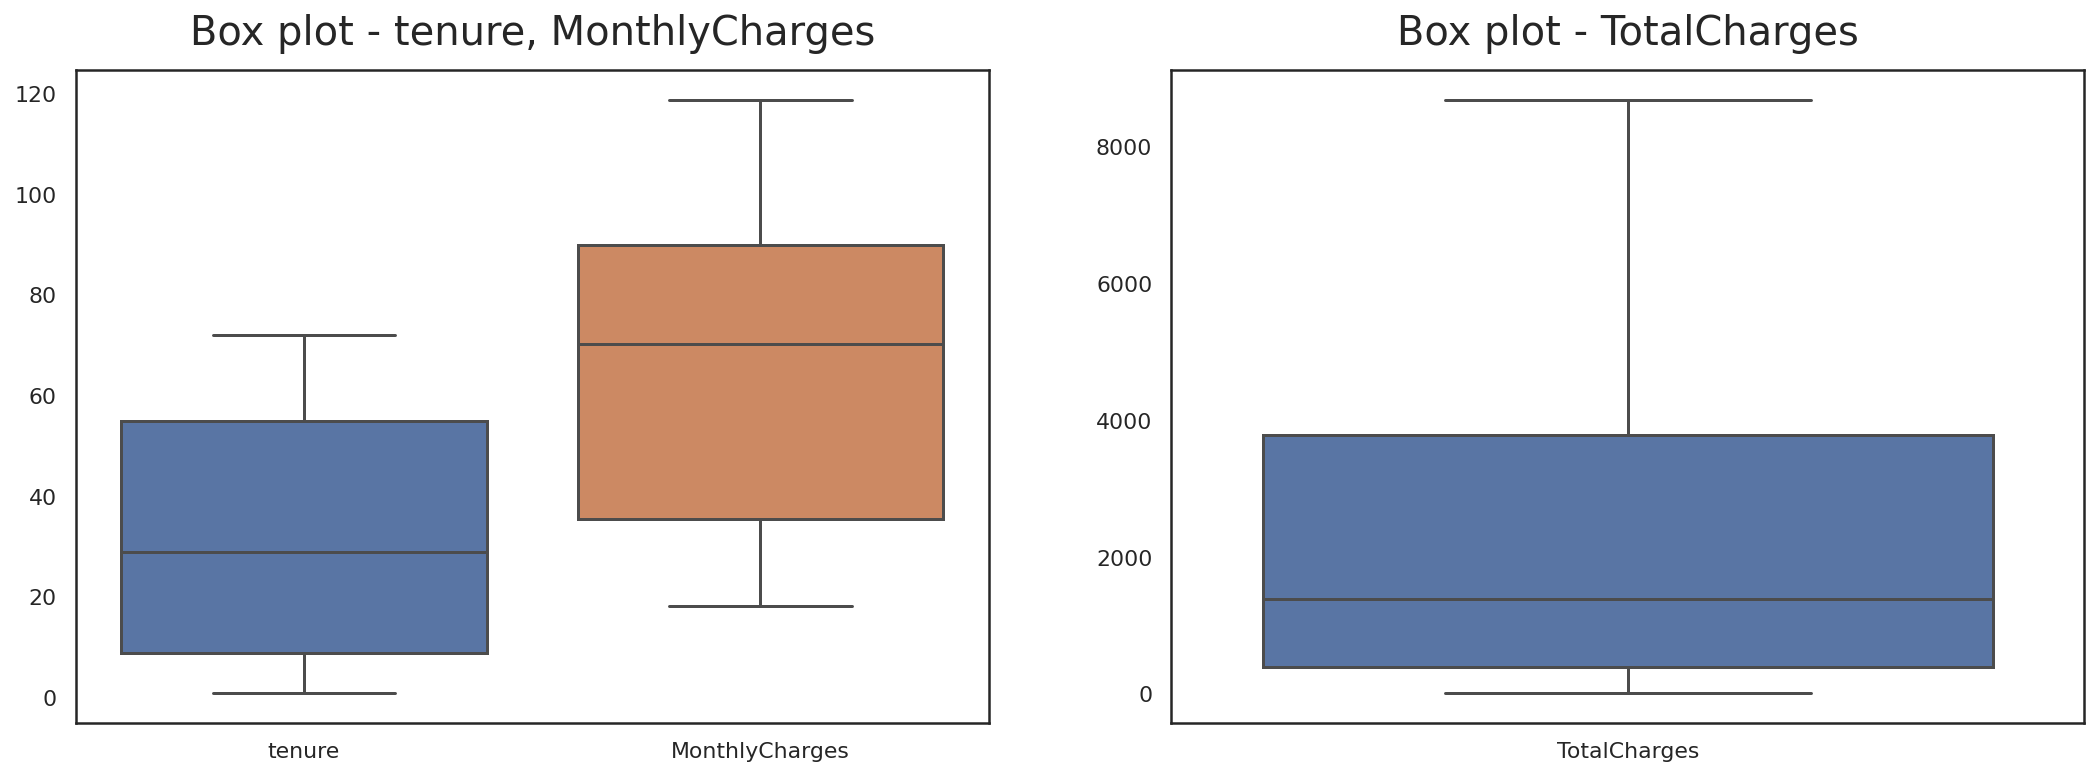

In [18]:
# boxplot으로 이상치 확인.

fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(data=df[['tenure','MonthlyCharges']], ax=ax[0])
ax[0].set_title('Box plot - tenure, MonthlyCharges', fontsize=20, y=1.02)

sns.boxplot(data=df[['TotalCharges']], ax=ax[1])
ax[1].set_title('Box plot - TotalCharges',fontsize=20, y=1.02)

plt.show()

**연속형 데이터에서 이상치 없는 것 확인.**

In [19]:
# kdeplot
def kdeplot(col, n):
  sns.kdeplot(df[df['Churn'] == 0][col], ax=ax[n])
  sns.kdeplot(df[df['Churn'] == 1][col], ax=ax[n])
  ax[n].set_title(f'KDE - {col}', fontsize=15)
  ax[n].legend(['Retention', 'Churn'])
  ax[n].set_ylabel('')

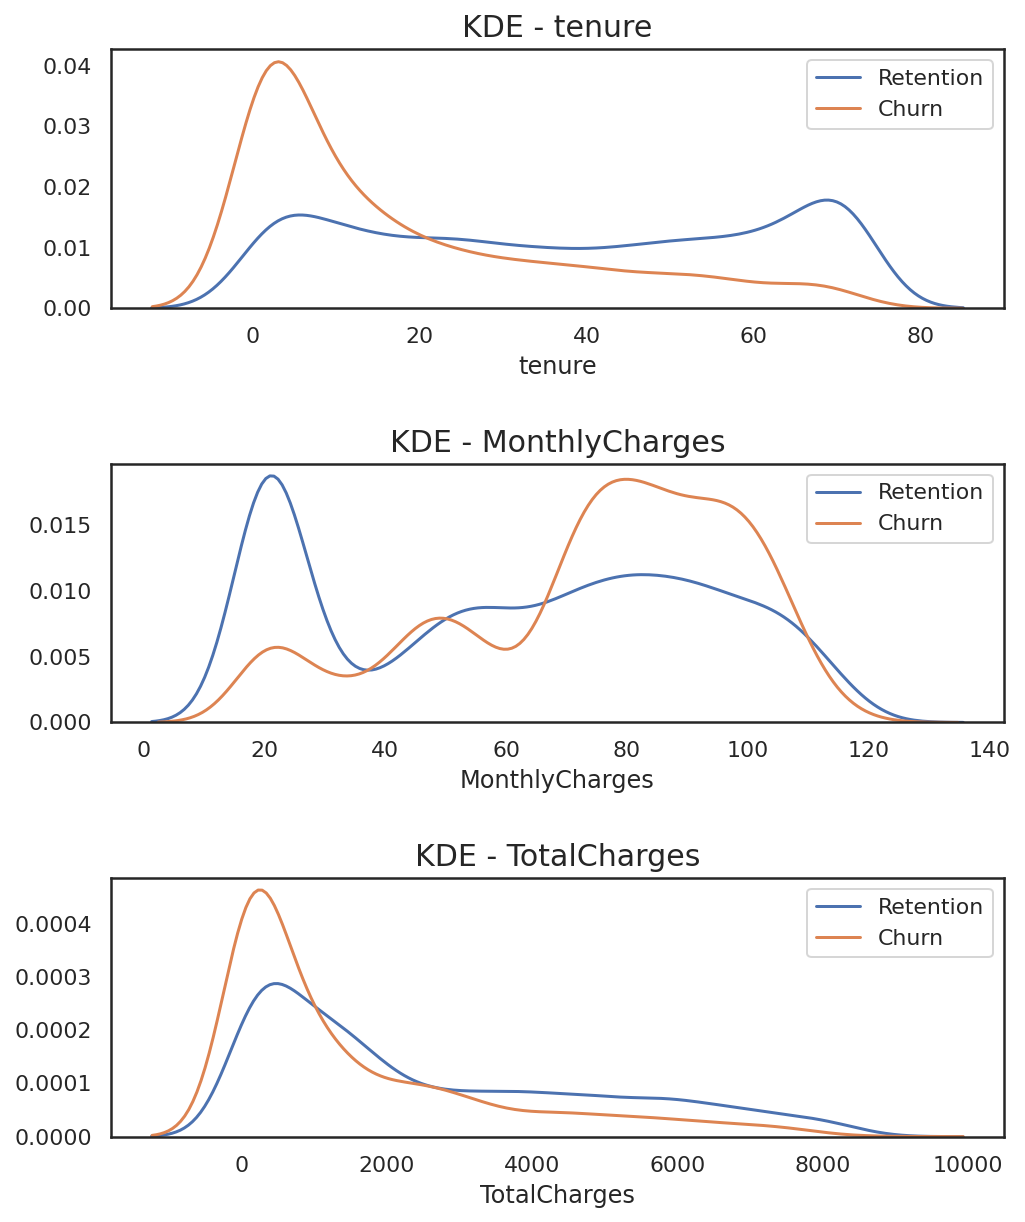

In [20]:
# 연속형 데이터 확률밀도함수 그래프
fig, ax = plt.subplots(3,1,figsize=(8,10))

kdeplot('tenure', 0)
kdeplot('MonthlyCharges', 1)
kdeplot('TotalCharges', 2)

plt.subplots_adjust(hspace=0.6)
plt.show()

### **확률밀도함수로 알 수 있는 것.**

1. 누적 가입기간이 짧을 수록 이탈할 확률이 높다.
2. 월 요금이 약 20달러인 경우 고객이 잘 유지되나, 약 65~110달러로 높아지면 이탈할 확률이 높아진다.
3. 누적요금 변수는 이탈에 큰 영향을 끼친다고 보기는 어려움.



### **고객의 상태와 관련된 특성들**

*gender, SeniorCitizen, Partner,Dependents*

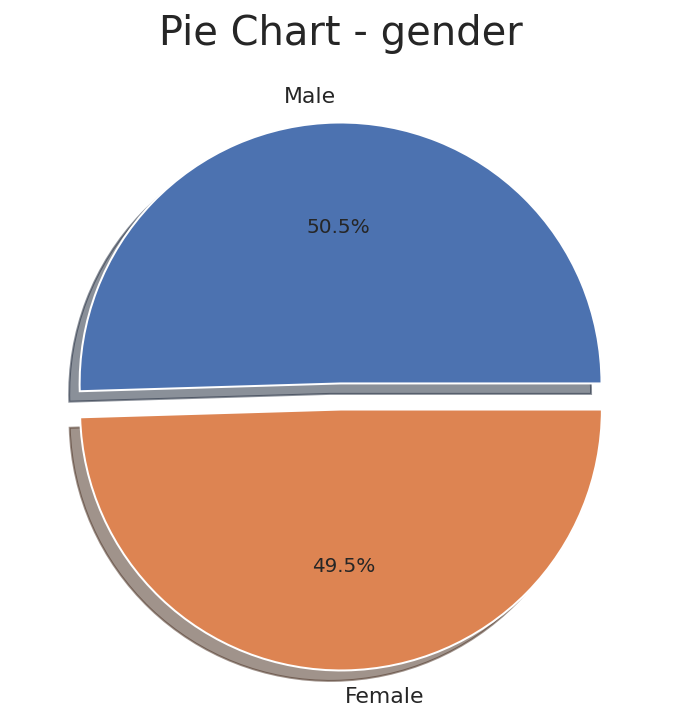

In [21]:
pieplot('gender')

고객들의 성비는 비슷하다.

In [22]:
def countplot(col):
  ax=sns.countplot(col, hue='Churn', data=df)
  ax.set_title(f'Churn by {col}', fontsize=15)

  # 각각의 바 위에 값 추가.
  for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+15, p.get_height(), ha='center', size=10)

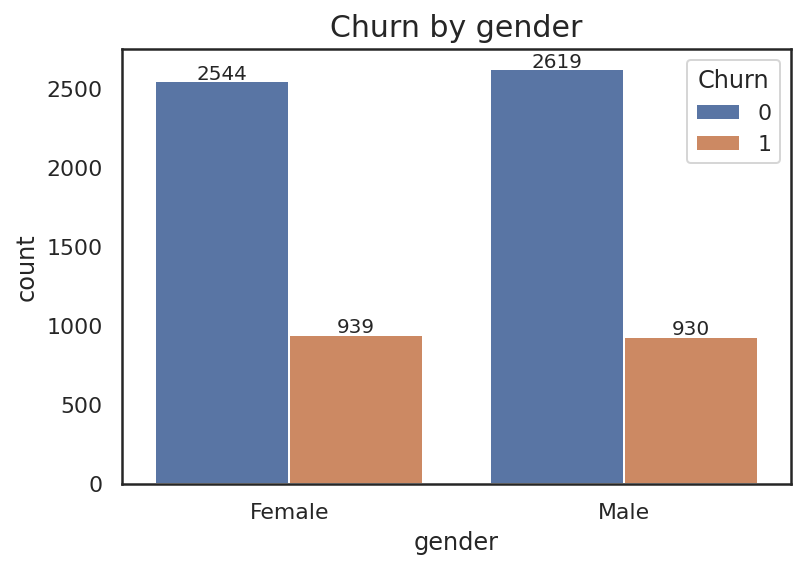

In [23]:
# gender 별 이탈 정도 확인.
countplot('gender')

plt.show()

**성별이 이탈에 큰 영향을 끼친다고 보기는 힘들다.**

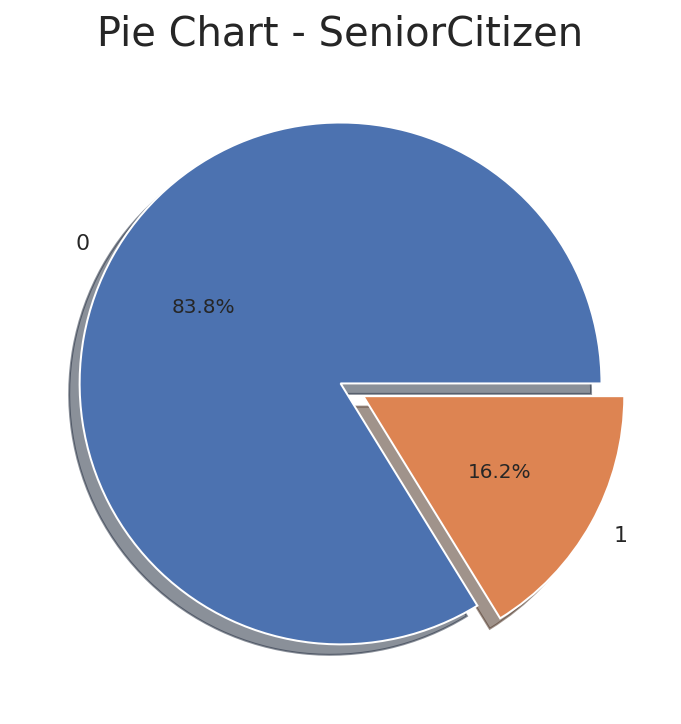

In [24]:
pieplot('SeniorCitizen')

고객 중 65세 이상인 고객은 16%로 **65세 미만이 훨씬 많은 비중을 차지한다.**

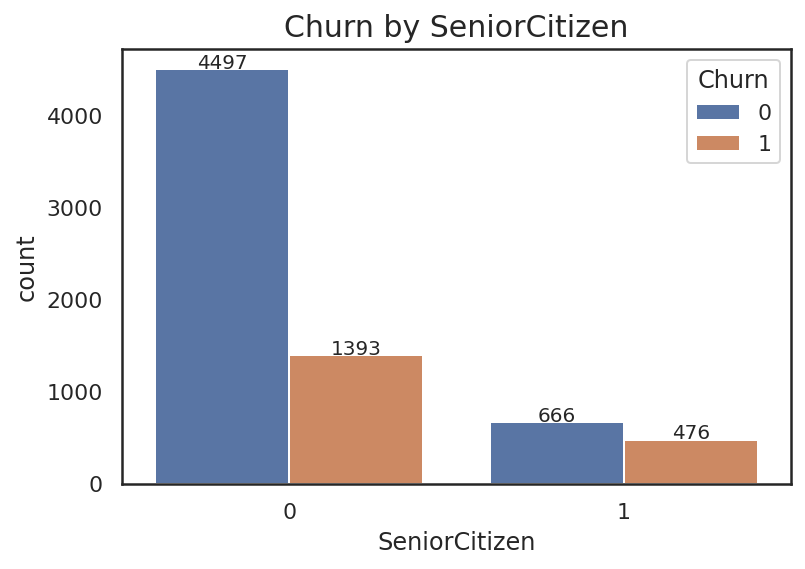

In [25]:
# 고객의 연령에 따른 이탈 정도
countplot('SeniorCitizen')

plt.show()

**65세 이상인 경우 이탈이 더 많은 것 같지만 정도를 확인하기 위해 퍼센테이지로도 확인**

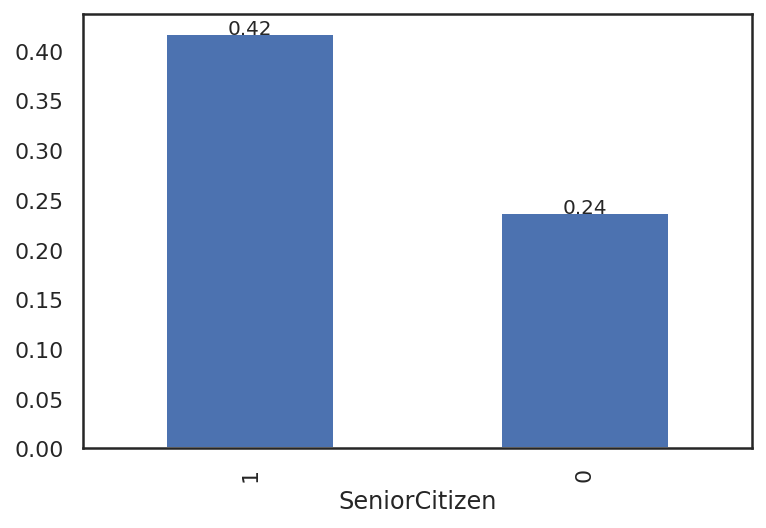

In [26]:
# 연령별 이탈 정도를 퍼센테이지로 한번 더 확인

def barplot_churnratio(col):
  ax = df.groupby(col)['Churn'].mean().sort_values(ascending=False).plot.bar()

  for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height(), f'{p.get_height():.2f}', ha='center', size=10)
  plt.show()

barplot_churnratio('SeniorCitizen')

**65세 이상인 경우 이탈률이 42%로 65세 미만인 경우의 24% 보다 더 높은 것을 확인할 수 있다.**

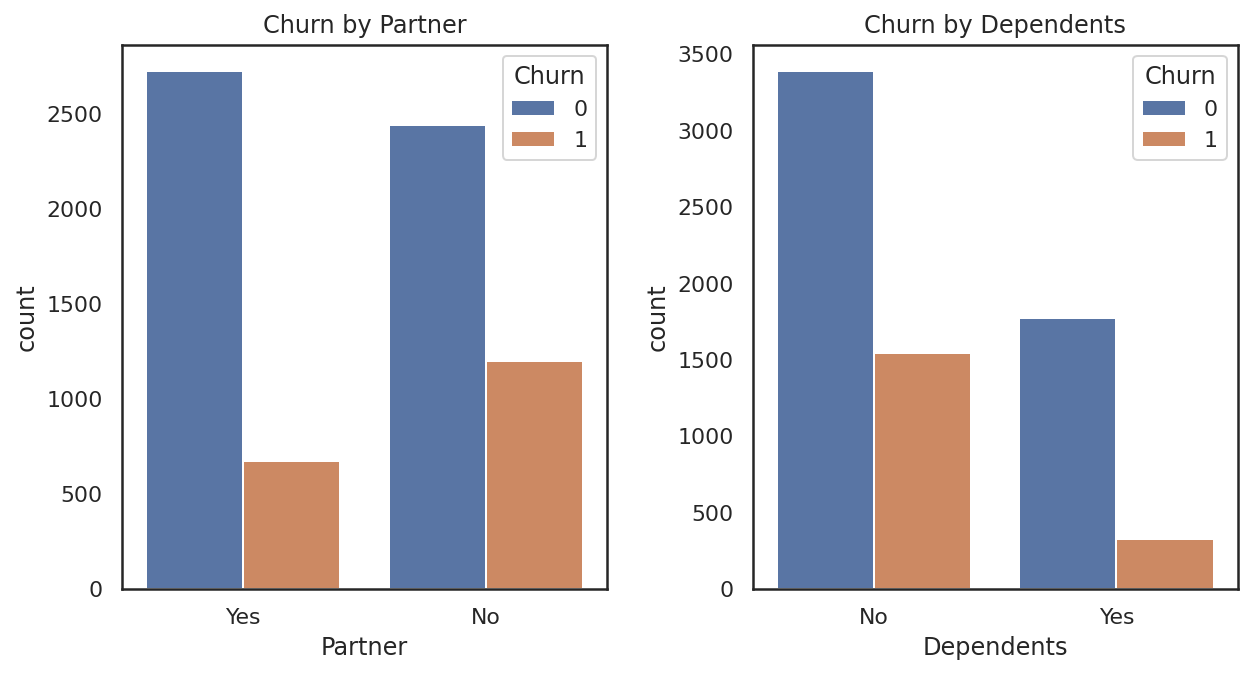

In [27]:
# Partner, Dependents
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.countplot('Partner', hue='Churn', data=df, ax=ax[0])
ax[0].set_title('Churn by Partner')

sns.countplot('Dependents', hue='Churn', data=df, ax=ax[1])
ax[1].set_title('Churn by Dependents')

plt.subplots_adjust(wspace=.3)
plt.show()

**파트너가 있는 경우, 부양가족이 있는 경우에 이탈 고객이 더 적다**




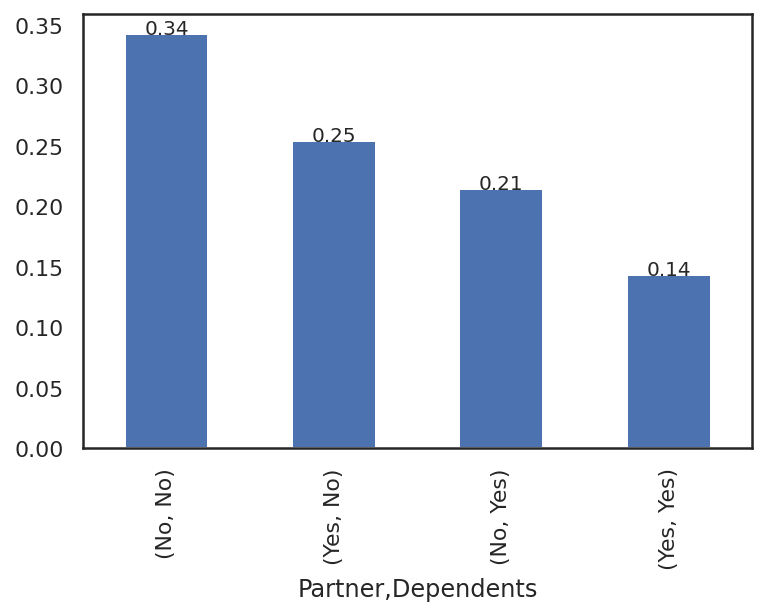

In [28]:
barplot_churnratio(['Partner', 'Dependents'])

**혼자사는 경우 이탈률이 증가하고, 파트너도 있고 부양가족도 있는 즉, 가족과 함께 사는 경우 14%로 이탈률이 감소한다.**

**고객은 크게 세 분류로 분류할 수 있다.**

1. Phone service만 구독하는 고객.
2. Internet service만 구독하는 고객.
3. 둘다 구독하는 고객.

### **Phone Service**

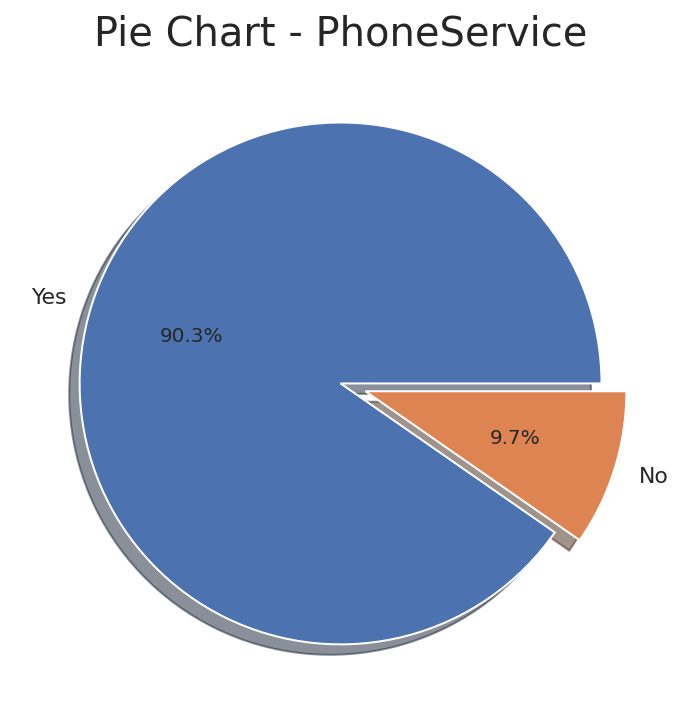

In [29]:
# 폰서비스 가입자 비율
pieplot('PhoneService', df)

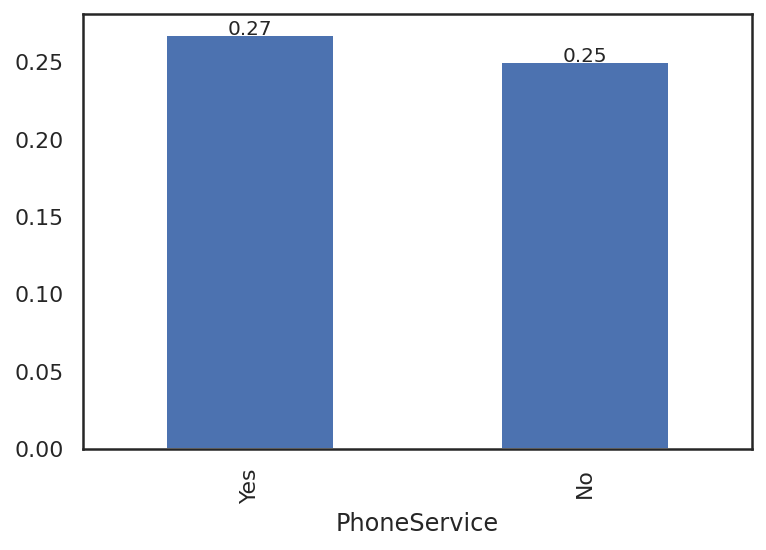

In [30]:
# 전화 서비스 가입자 비율이 훨씬 높기때문에 이탈 차이를 비율로 확인.
barplot_churnratio('PhoneService')

전화 서비스 가입 유무는 **이탈 정도의 큰 영향을 끼치지 않는다.**

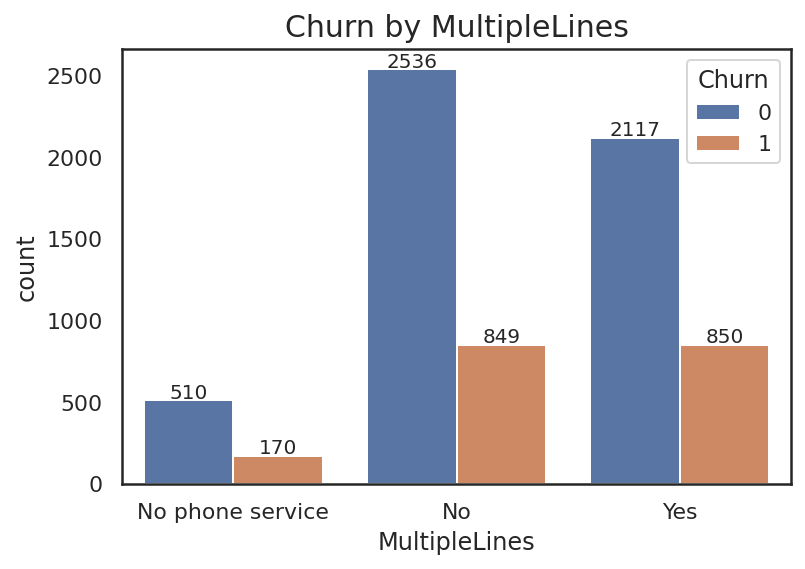

In [31]:
# MultipleLines 서비스 구독과 이탈 정도
countplot('MultipleLines')

다중 전화선 서비스는 **이탈에 큰 영향을 주지 않는다고 볼 수 있다.**

### **Internet Service**

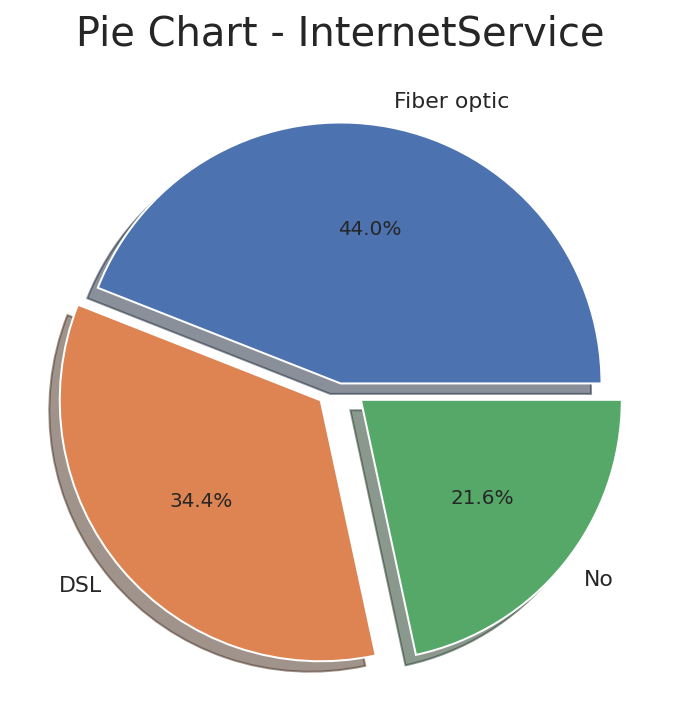

In [32]:
# 인터넷 서비스 고객 비율
pieplot('InternetService',df)

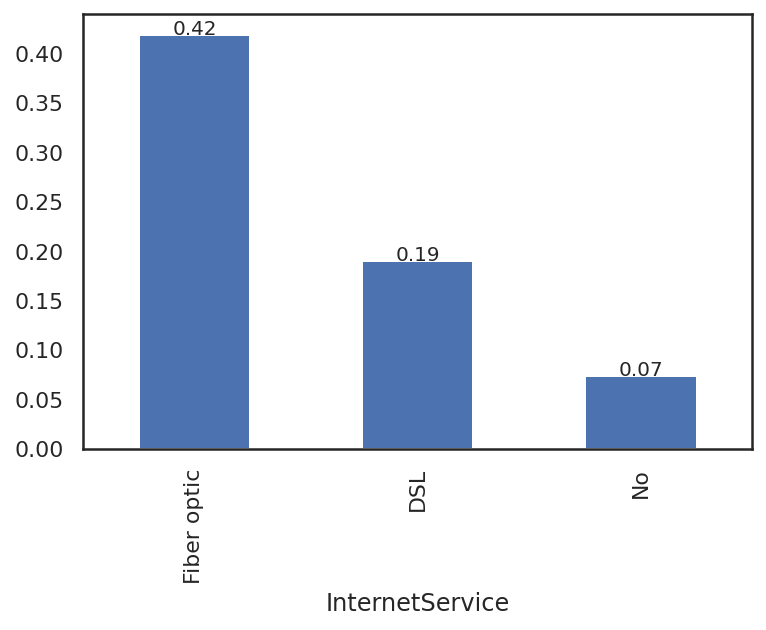

In [33]:
barplot_churnratio('InternetService')

Fiber optic **이용자가 가장 많고 이탈률도 가장 높다.**

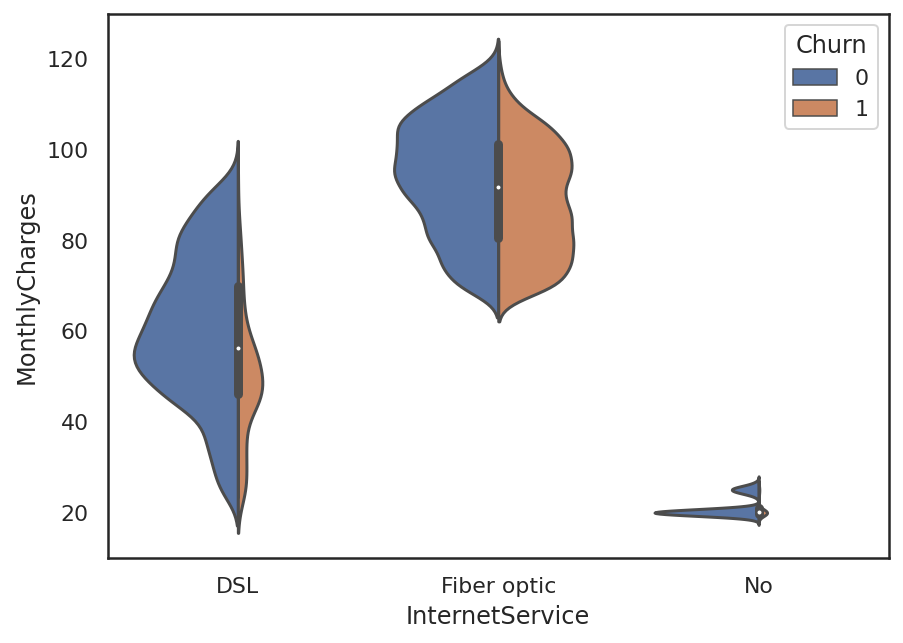

In [34]:
plt.figure(figsize=(7,5))

sns.violinplot('InternetService', 'MonthlyCharges', hue='Churn', scale='count',data=df, split=True)
plt.show()

Fiber optic 서비스를 이용하는 고객의 경우 **MonthlyCharges 중앙값이 KDE plot으로 확인했을 때 이탈 가능성이 가장 높았던 80과 100사이에 위치해 있는 걸 확인할 수 있다.** 즉, **높은 가격 대비 서비스의 만족도가 높지 않을 가능성이 있다**고 생각할 수 있다.

DSL의 경우 특이하게 **가격이 높은 지점보다 다소 낮은 지점에서 이탈이 더 많이 일어나는 현상을 보인다.**

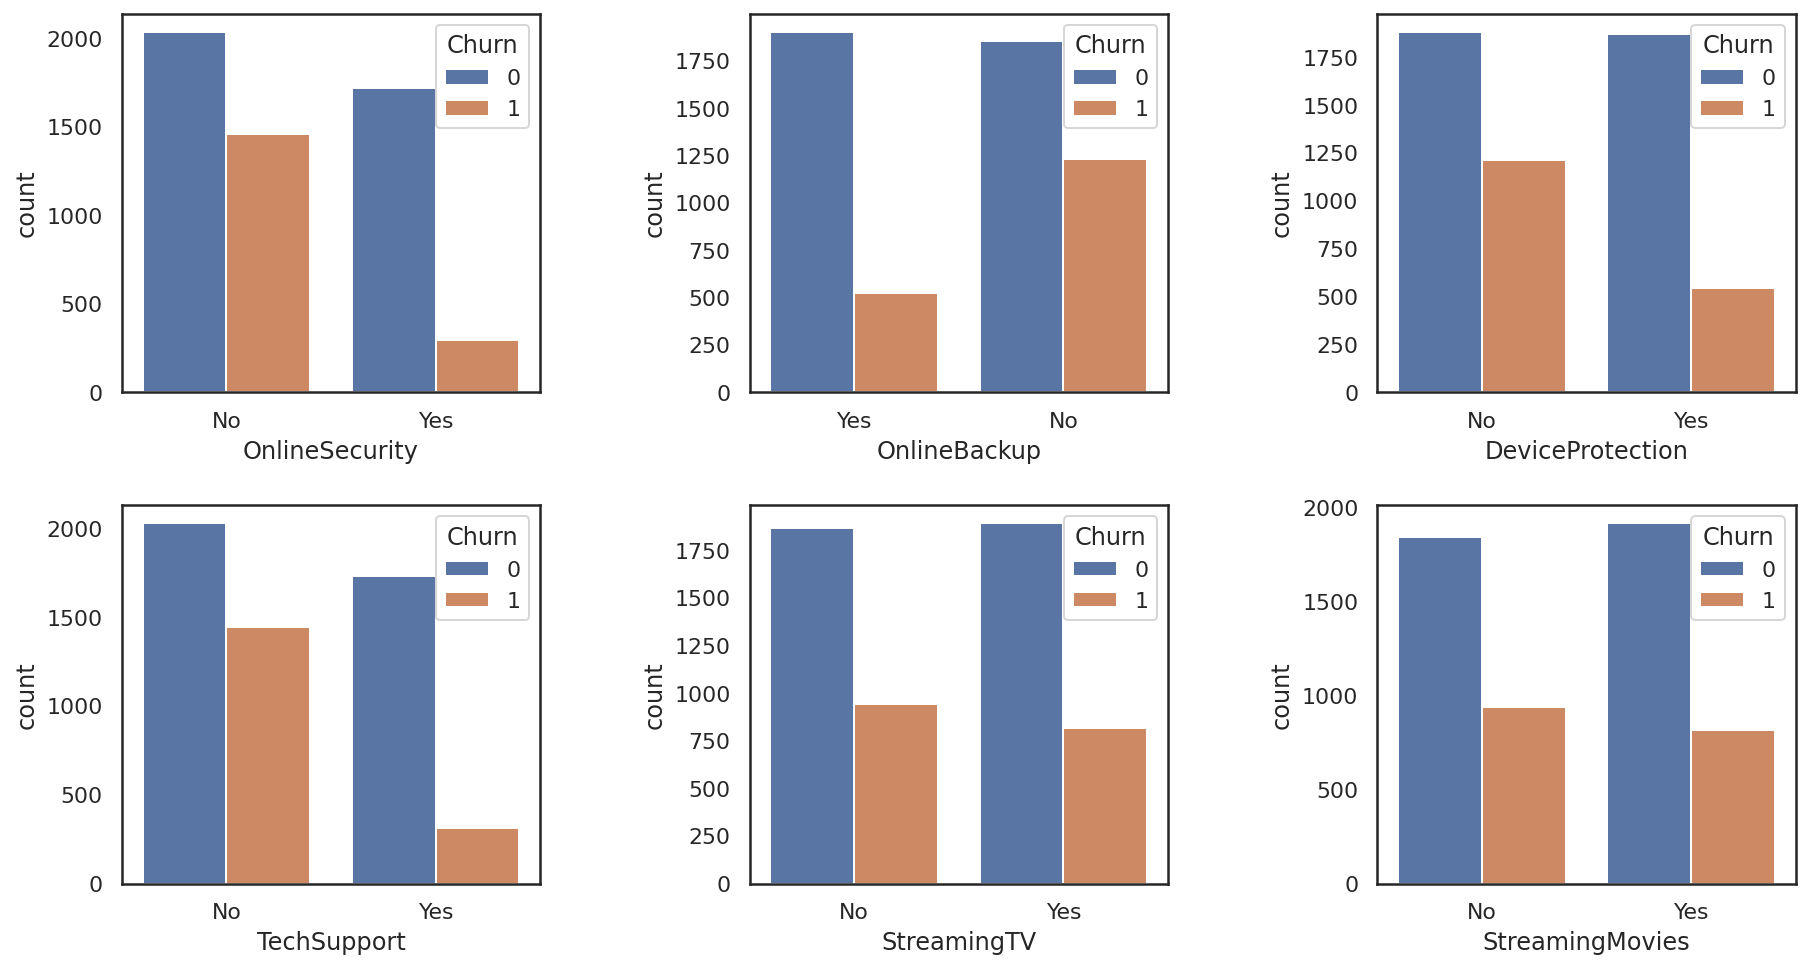

In [35]:
# 인터넷 서비스와 연동된 서비스

fig, ax = plt.subplots(2,3, figsize=(15,8))

# 인터넷 서비스에 가입하지 않은 경우는 제외.
sns.countplot('OnlineSecurity', hue='Churn', data=df[df['OnlineSecurity'] != 'No internet service'], ax=ax[0,0])
sns.countplot('OnlineBackup', hue='Churn', data=df[df['OnlineBackup'] != 'No internet service'], ax=ax[0,1])
sns.countplot('DeviceProtection', hue='Churn', data=df[df['DeviceProtection'] != 'No internet service'], ax=ax[0,2])
sns.countplot('TechSupport', hue='Churn', data=df[df['TechSupport'] != 'No internet service'], ax=ax[1,0])
sns.countplot('StreamingTV', hue='Churn', data=df[df['StreamingTV'] != 'No internet service'], ax=ax[1,1])
sns.countplot('StreamingMovies', hue='Churn', data=df[df['StreamingMovies'] != 'No internet service'], ax=ax[1,2])

plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()

스트리밍 서비스를 제외하고는 **부가 서비스를 구독한 고객의 경우 이탈률이 더 낮았다.** 반면 스트리밍 서비스는 **큰 차이를 보이지 않았다.**

### **Phone & Internet Service**

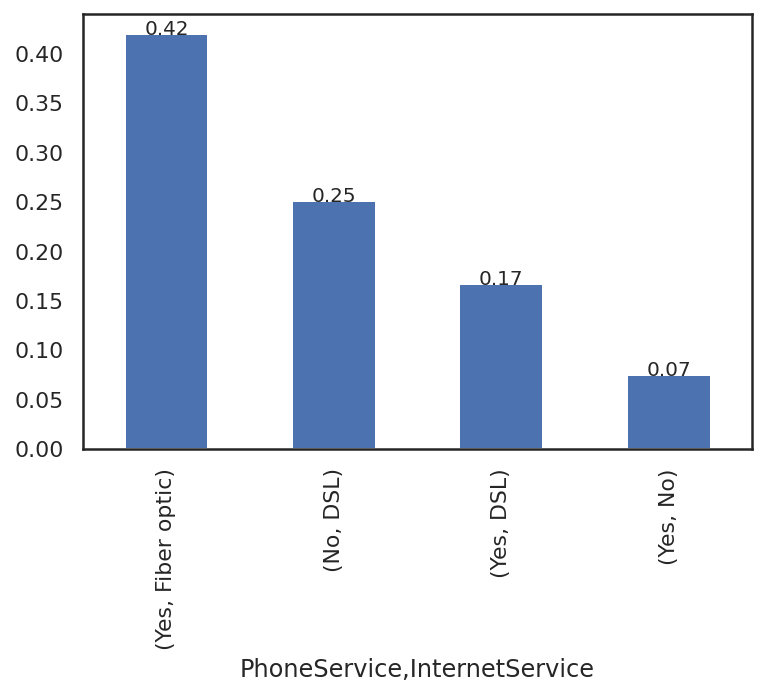

In [36]:
# 전화와 인터넷 서비스로 분류한 고객별 이탈률
barplot_churnratio(['PhoneService', 'InternetService'])

In [37]:
# 각 고객이 총 고객에서 얼만큼의 비율을 차지하는지 확인.
phone_internet = df[['PhoneService', 'InternetService', 'Churn']].groupby(['PhoneService', 'InternetService']).count()
phone_internet['customer_ratio'] = phone_internet['Churn'] / len(df)
phone_internet

Churn  customer_ratio
PhoneService InternetService                       
No           DSL                680        0.096701
Yes          DSL               1736        0.246871
             Fiber optic       3096        0.440273
             No                1520        0.216155

전화 서비스와 **Fiber optic(광섬유 인터넷)을 이용하는 고객의 비율이 전체 고객 중 44%로 많은데, 이탈률도 42%로 가장 높다.** 반면, **전화 서비스만 이용하는 고객의 이탈률은 7%로 매우 낮다.** 이를 통해 **인터넷 서비스에 고객들의 불만이 많을 것**이라고 예측해 볼 수 있다. 또한 **Fiber optic의 경우 타사에 비해 성능이나 가격적인 면에서 부족할 것**이라고 예측해 볼 수 있다.

### **계약 단위(Contract)**

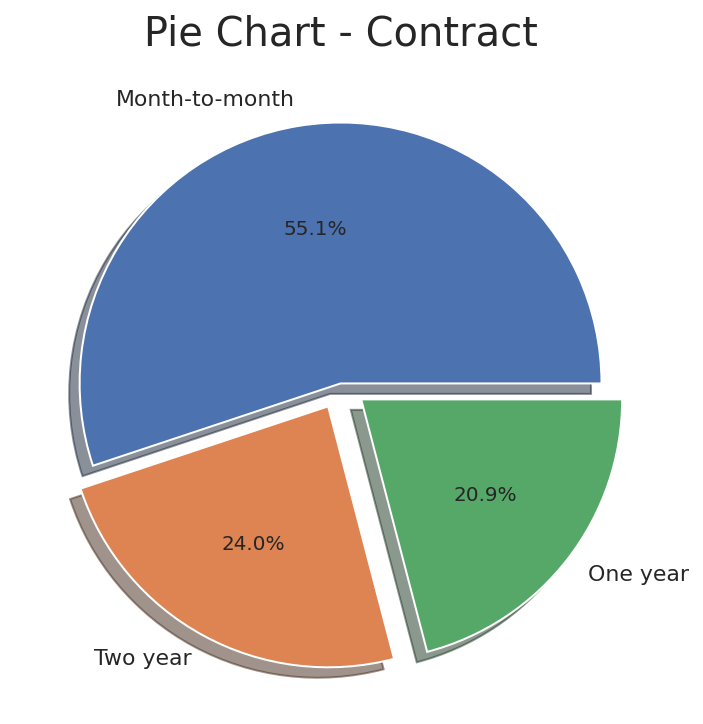

In [38]:
# 계약 단위의 비율.
pieplot('Contract', df)

월 단위로 계약하는 경우가 55%로 가장 많다.

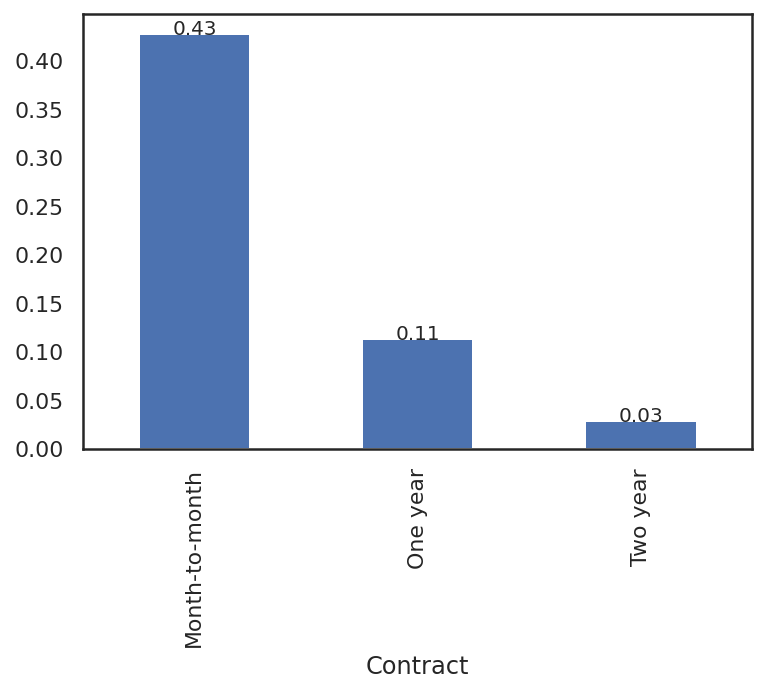

In [39]:
# 계약 단위 별 이탈률
barplot_churnratio('Contract')

월 단위로 계약했을때 **이탈률이 43%로 가장 높다.** 1년이나 2년 계약의 경우 **위약금 문제로 인해 이탈이 적을 것으로 예상.**

### **전자명세서(PaperlessBilling)**

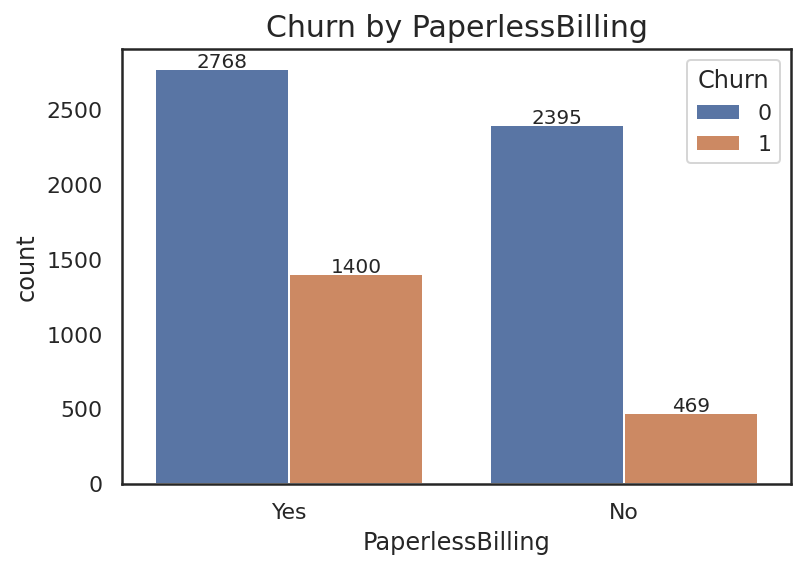

In [40]:
# 전자명세서 사용 여부.
countplot('PaperlessBilling')
plt.show()

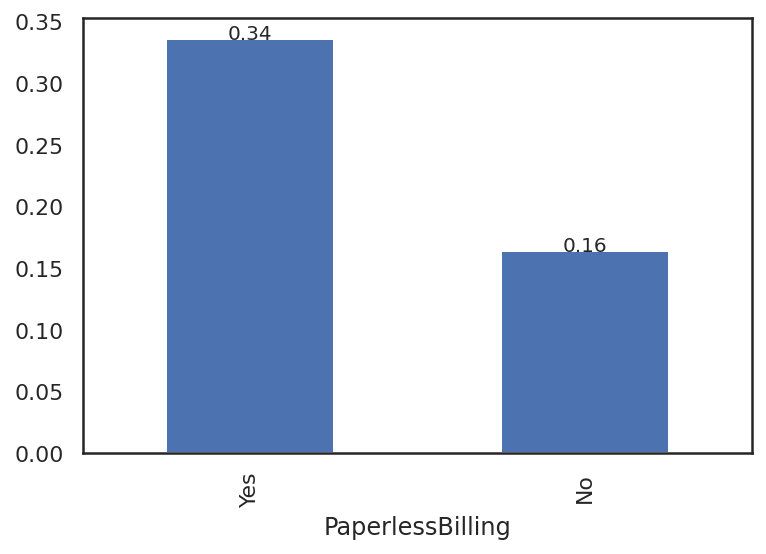

In [41]:
barplot_churnratio('PaperlessBilling')

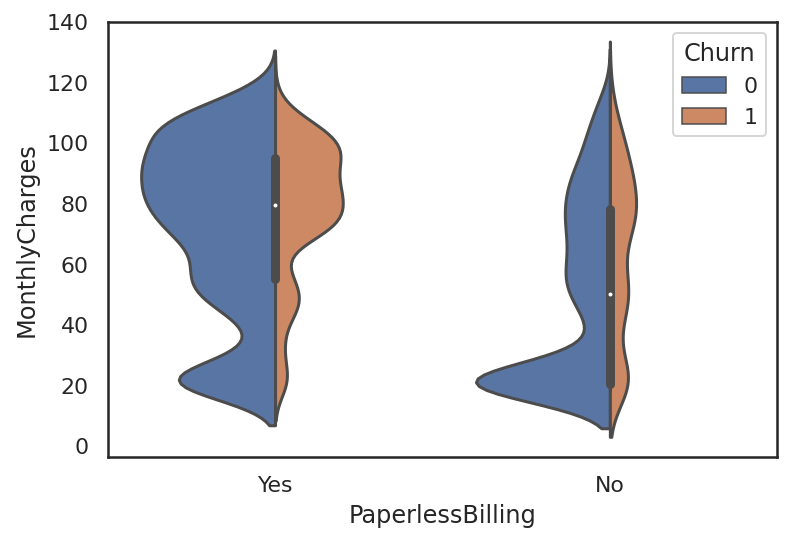

In [42]:
sns.violinplot('PaperlessBilling', 'MonthlyCharges', hue='Churn', data=df, scale='count',split=True)
plt.show()

전자명세서를 사용하는 경우 **월 납부 요금이 더 비싸고, 가격에 더 예민하게 반응하는듯 하다.**




###**결제 방법(PaymentMethod)**

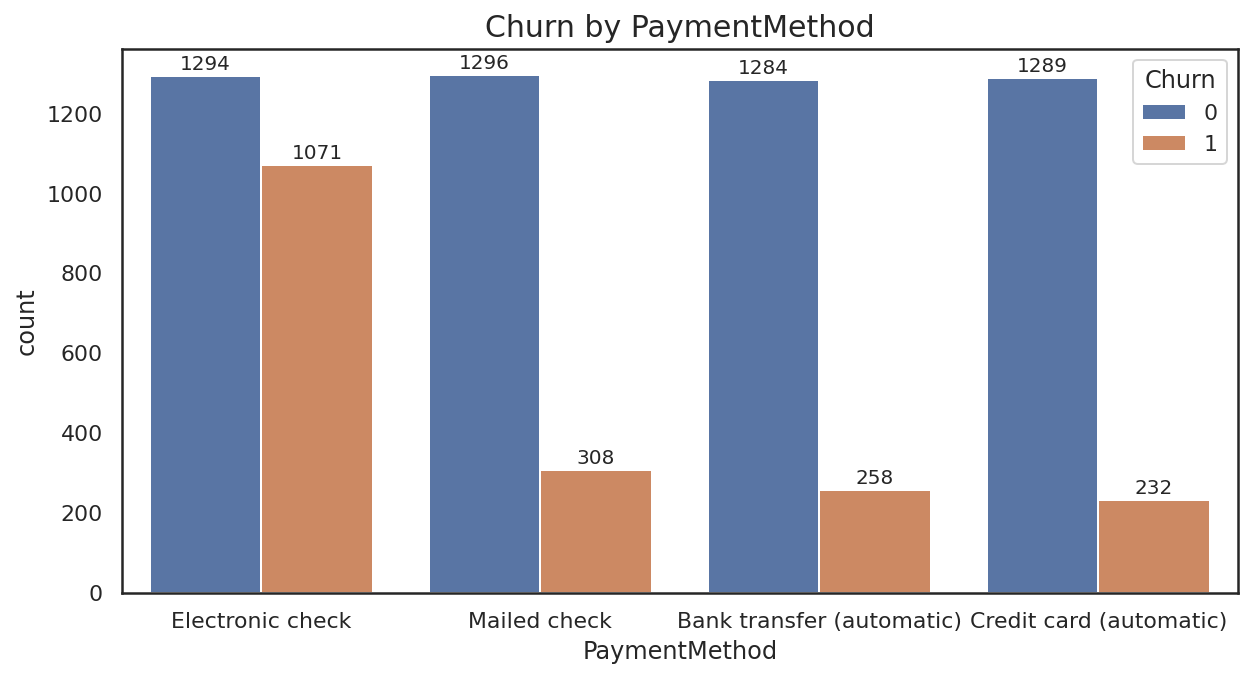

In [43]:
# 결제 방법

plt.figure(figsize=(10,5))
countplot('PaymentMethod')

plt.show()

전자 결제 시스템을 이용하는 경우 **이탈 고객이 가장 많다.**

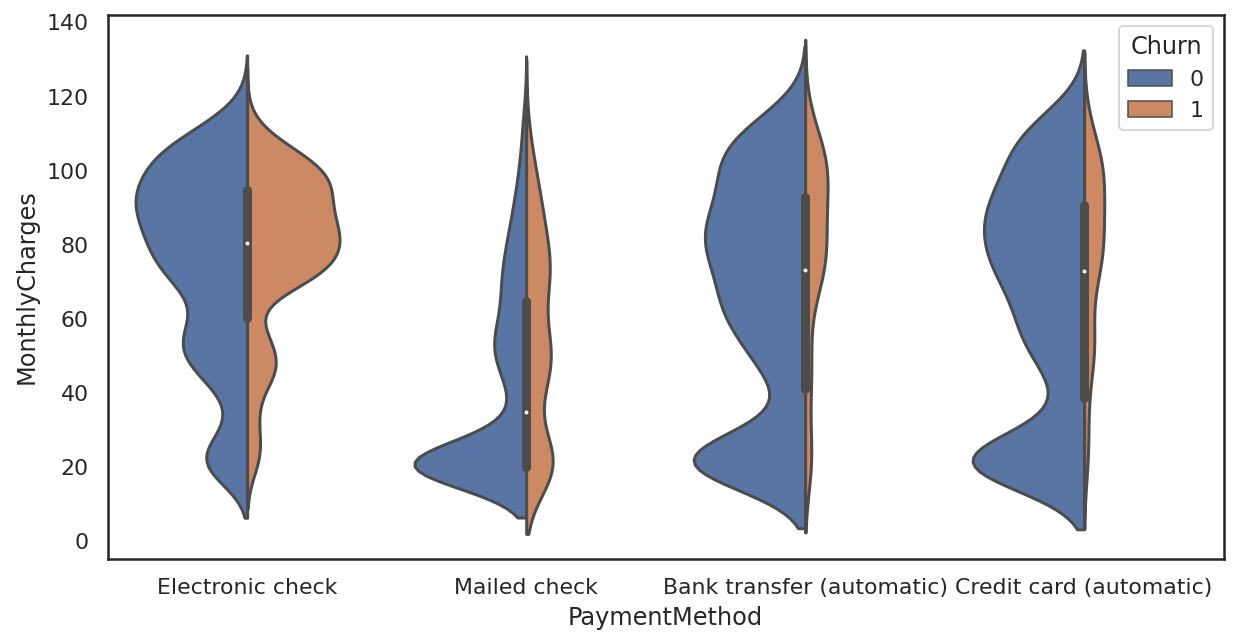

In [44]:
plt.figure(figsize=(10,5))
sns.violinplot('PaymentMethod', 'MonthlyCharges', hue='Churn', data=df, scale='count' ,split=True)

plt.show()

1. 우편 송금 방식(Mailed check)의 경우 가격이 **가장 저렴한 편이다.**
2. 전자 송금방식의 경우 **대부분 가격이 높은 쪽에 형성되어 있고 가격에 예민하게 반응한다.**
3. 자동으로 결제가 진행되는 경우 **가격에 좀 더 둔감하게 반응하는 것을 보인다.**

## **EDA 결과 정리**

1. 성별(gender), 스트리밍 서비스(StreamingTV, StreamingMovies), 누적 요금(TotalCharges) 등은 타겟 데이터인 Churn에 큰 영향을 끼친다고 보기는 어렵다.
2. 인터넷 서비스의 경우 스트리밍 서비스를 제외하고는 부가 서비스를 추가적으로 구독한 경우 이탈률이 낮아졌다.
3. Fiber optic의 경우 사용자도 많았지만, 이탈하는 고객도 굉장히 많았다. (서비스 개선이 필요해보인다.)
4. 가격이 높거나, 가격을 더 자주 접할 수 있는 정도(자동 결제와 전자명세서 등)의 차이에 이탈률이 달라진 걸 볼 수 있었다. 즉, 전체적으로 이탈률은 가격에 많은 영향을 받는 듯 하다.

## **Feature Engineering**

In [45]:
# React : EDA 결과 가격을 더 자주 확인할 수 있는 환경일 수록 가격에 민감하게 반응
# PaymentMethod : Electronic check, PaperlessBilling : yes => 전자 결제와, 전자명세서를 사용하는 경우 1씩 추가
react = []
for method, paperless in zip(df['PaymentMethod'], df['PaperlessBilling']):
  score = 0
  if method == 'Electronic check':
    score += 1
  if paperless == 'Yes':
    score += 1
  react.append(score)

df['React'] = react

# AddServiceInternet : 인터넷 부가서비스를 가입하면 이탈률이 낮은 경향이 있다. 스트리밍을 제외한 다른 서비스를 더 많이 구독할 수록 이탈률이 줄어들 것으로 예상.
add_service = []
for secu, back, prot, tech in zip(df['OnlineSecurity'], df['OnlineBackup'], df['DeviceProtection'], df['TechSupport']):
  score = 0
  if secu == 'Yes':
    score += 1
  if back == 'Yes':
    score += 1
  if prot == 'Yes':
    score += 1
  if tech == 'Yes':
    score += 1
  add_service.append(score)

df['AddServiceInternet'] = add_service

In [46]:
# 필요없는 열 제거.
df.drop(columns=['customerID', 'gender'], inplace=True)

## **모델 성능 비교**

1. LogisticRegression
2. RandomForestClassifier
3. XGBClassifier
4. LGBMClassifier
5. CatBoostClassifier

고객 이탈의 경우 **이탈하지 않을 고객을 이탈한다고 판단할 경우 손해가 발생**하기에, **재현율과 위양성률을 바탕으로 한 AUC score를 중점적으로 활용하여 모델의 성능을 비교.**

In [48]:
# 데이터를 훈련 데이터와 검증 데이터로 나눈다.
target = 'Churn'
feature = df.columns.drop('Churn')

train = df[feature]
test = df[target]

# 타겟 비슷한 비율로 split
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=.2, stratify=test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 20), (1407, 20), (5625,), (1407,))

In [49]:
# 타겟 비율 비슷하게 나눠졌는지 확인.
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.734222
1    0.265778
Name: Churn, dtype: float64
0    0.734186
1    0.265814
Name: Churn, dtype: float64


In [50]:
# 데이터 전처리

preprocessor_pipe = make_pipeline(
    OrdinalEncoder(),
    StandardScaler()
    )

X_train_preprocessed = preprocessor_pipe.fit_transform(X_train)
X_test_preprocessed = preprocessor_pipe.transform(X_test)

In [51]:
# 훈련 & 검증 데이터셋 예측 결과 만드는 함수.

def model_predict(model, train_set, test_set):
  pred_train = model.predict(train_set)
  pred_test = model.predict(test_set)
  pred_proba_train = model.predict_proba(train_set)[:,1]
  pred_proba_test = model.predict_proba(test_set)[:,1]

  return pred_train, pred_test, pred_proba_train, pred_proba_test

### **Base model**

In [ ]:
# 최빈 클래스
major = y_train.mode()[0]
base_pred_train = [major] * len(y_train)
base_pred_test = [major] * len(y_test)

In [ ]:
print('훈련 데이터셋')
print('accuracy_score :', accuracy_score(y_train, base_pred_train))
print('roc_auc_score :', roc_auc_score(y_train, base_pred_train))
print('---'*13)
print('검증 데이터셋')
print('accuracy_score :', accuracy_score(y_test, base_pred_test))
print('roc_auc_score :', roc_auc_score(y_test, base_pred_test))

훈련 데이터셋
accuracy_score : 0.7342222222222222
roc_auc_score : 0.5
---------------------------------------
검증 데이터셋
accuracy_score : 0.7341862117981521
roc_auc_score : 0.5


최빈 클래스로 예측할 경우 **정확도는 0.73이지만 AUC score는 0.5**

### **모델 생성**

In [ ]:
# LogisticRegression

log = LogisticRegression(class_weight='balanced')

log.fit(X_train_preprocessed, y_train)

log_pred_train, log_pred_test, log_proba_train, log_proba_test = model_predict(log, X_train_preprocessed, X_test_preprocessed)

In [ ]:
# RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', max_depth=6, random_state=2)

rf.fit(X_train_preprocessed, y_train)

rf_pred_train, rf_pred_test, rf_proba_train, rf_proba_test = model_predict(rf, X_train_preprocessed, X_test_preprocessed)

In [ ]:
# XGBClassifier

xgb = XGBClassifier(sacle_pos_weight=4, max_depth=6, random_state=2)
              
xgb.fit(X_train_preprocessed, y_train)

xgb_pred_train, xgb_pred_test, xgb_proba_train, xgb_proba_test = model_predict(xgb, X_train_preprocessed, X_test_preprocessed)

In [ ]:
# LGBMClassifier

lgb = LGBMClassifier(class_weight='balanced',max_depth=5, random_state=2)

lgb.fit(X_train_preprocessed, y_train)

lgb_pred_train, lgb_pred_test, lgb_proba_train, lgb_proba_test = model_predict(lgb, X_train_preprocessed, X_test_preprocessed)

In [ ]:
# CatBoostClassifier

cat_feature = list(np.where(X_train.dtypes != float)[0])
cat_feature

cat = CatBoostClassifier(iterations=5,
                         depth = 6,
                         random_state=2)

cat.fit(X_train_preprocessed, y_train,
        cat_features = cat_feature.remove(3),
        eval_set = (X_test_preprocessed,y_test),
        verbose = False
        )

cat_pred_train, cat_pred_test, cat_proba_train, cat_proba_test = model_predict(cat, X_train_preprocessed, X_test_preprocessed)

In [ ]:
# 모델 성능 비교표 만드는 함수.
def result_report(model_names, train_preds, test_preds, train_probas, test_probas, y_train_true, y_test_true) :

  train_acc = []
  train_precision = []
  train_recall = []
  train_f1_score = []
  train_auc = []

  test_acc = []
  test_precision = []
  test_recall = []
  test_f1_score = []
  test_auc = []

  for train, test, train_proba, test_proba in zip(train_preds, test_preds, train_probas, test_probas):
    train_acc.append(f'{accuracy_score(y_train_true, train):.3f}')
    train_precision.append(f'{precision_score(y_train_true, train):.3f}')
    train_recall.append(f'{recall_score(y_train_true, train):.3f}')
    train_f1_score.append(f'{f1_score(y_train_true, train):.3f}')
    train_auc.append(f'{roc_auc_score(y_train_true, train_proba):.3f}')

    test_acc.append(f'{accuracy_score(y_test_true, test):.3f}')
    test_precision.append(f'{precision_score(y_test_true, test):.3f}')
    test_recall.append(f'{recall_score(y_test_true, test):.3f}')
    test_f1_score.append(f'{f1_score(y_test_true, test):.3f}')
    test_auc.append(f'{roc_auc_score(y_test_true, test_proba):.3f}')

  report = pd.DataFrame({'Model' : model_names, 'train_accuracy' : train_acc, 'train_precision' : train_precision, 'train_recall' : train_recall,
                         'train_f1_score' : train_f1_score, 'train_auc' : train_auc,'test_accuracy' : test_acc, 'test_precision' : test_precision, 'test_recall' : test_recall,
                         'test_f1_score' : test_f1_score, 'test_auc' : test_auc })
  
  return report

### **모델 성능 비교**

In [ ]:
# 모델 성능 비교
model_names = ['Logistic', 'RF', 'XGB', 'LGB', 'CAT']
train_preds = [log_pred_train, rf_pred_train, xgb_pred_train, lgb_pred_train, cat_pred_train]
test_preds = [log_pred_test, rf_pred_test, xgb_pred_test, lgb_pred_test, cat_pred_test]
train_pobas = [log_proba_train, rf_proba_train, xgb_proba_train, lgb_proba_train, cat_proba_train]
test_probas = [log_proba_test, rf_proba_test, xgb_proba_test, lgb_proba_test, cat_proba_test]


result = result_report(model_names, train_preds, test_preds, train_pobas, test_probas, y_train ,y_test)
result

,Model,train_accuracy,train_precision,train_recall,train_f1_score,train_auc,test_accuracy,test_precision,test_recall,test_f1_score,test_auc
0,Logistic,0.760,0.533,0.795,0.638,0.847,0.763,0.538,0.749,0.626,0.834
1,RF,0.767,0.540,0.832,0.655,0.871,0.756,0.529,0.767,0.626,0.836
2,XGB,0.868,0.801,0.669,0.729,0.938,0.795,0.653,0.484,0.556,0.831
3,LGB,0.810,0.596,0.882,0.711,0.913,0.754,0.527,0.738,0.615,0.834
4,CAT,0.810,0.676,0.551,0.607,0.857,0.791,0.648,0.468,0.543,0.826


AUC Score는 RF, Logistic, CAT, LGB, XGB 순으로 높다.

### **Over Sampling 진행 후 모델 성능 비교**

In [ ]:
# oversampling 진행.
oversample = SMOTE(random_state=2)

X_train_res, y_train_res = oversample.fit_resample(X_train_preprocessed , y_train)

print('oversampling 적용 전 :', X_train.shape, y_train.shape)
print('oversampling 적용 후 :', X_train_res.shape, y_train_res.shape)

oversampling 적용 전 : (5625, 20) (5625,)
oversampling 적용 후 : (8260, 20) (8260,)


In [ ]:
# oversampling 후 모델 학습 진행.

# Logistic
log_res = LogisticRegression()

log_res.fit(X_train_res, y_train_res)

log_pred_train_res, log_pred_test_res, log_proba_train_res, log_proba_test_res = model_predict(log_res, X_train_res, X_test_preprocessed)

# RF
rf_res = RandomForestClassifier(max_depth=6, random_state=2)

rf_res.fit(X_train_res, y_train_res)

rf_pred_train_res, rf_pred_test_res, rf_proba_train_res, rf_proba_test_res = model_predict(rf_res, X_train_res, X_test_preprocessed)

# XGB
xgb_res = XGBClassifier(max_depth=6, random_state=2)

xgb_res.fit(X_train_res, y_train_res)

xgb_pred_train_res, xgb_pred_test_res, xgb_proba_train_res, xgb_proba_test_res = model_predict(xgb_res, X_train_res, X_test_preprocessed)

# LGB
lgb_res = LGBMClassifier(max_depth=5, random_state=2)

lgb_res.fit(X_train_res, y_train_res)

lgb_pred_train_res, lgb_pred_test_res, lgb_proba_train_res, lgb_proba_test_res = model_predict(lgb_res, X_train_res, X_test_preprocessed)

# CAT
cat_res = CatBoostClassifier(iterations=5,
                         depth = 6,
                         random_state=2)

cat_res.fit(X_train_res, y_train_res, verbose=False, eval_set=(X_test_preprocessed, y_test))

cat_pred_train_res, cat_pred_test_res, cat_proba_train_res, cat_proba_test_res = model_predict(cat_res, X_train_res, X_test_preprocessed)

In [ ]:
# SMOTE 결과
model_names = ['Logistic', 'RF', 'XGB', 'LGB', 'CAT']
train_preds = [log_pred_train_res, rf_pred_train_res, xgb_pred_train_res, lgb_pred_train_res, cat_pred_train_res]
test_preds = [log_pred_test_res, rf_pred_test_res, xgb_pred_test_res, lgb_pred_test_res, cat_pred_test_res]
train_pobas = [log_proba_train_res, rf_proba_train_res, xgb_proba_train_res, lgb_proba_train_res, cat_proba_train_res]
test_probas = [log_proba_test_res, rf_proba_test_res, xgb_proba_test_res, lgb_proba_test_res, cat_proba_test_res]

res_result = result_report(model_names, train_preds, test_preds, train_pobas, test_probas, y_train_res ,y_test)
res_result

,Model,train_accuracy,train_precision,train_recall,train_f1_score,train_auc,test_accuracy,test_precision,test_recall,test_f1_score,test_auc
0,Logistic,0.778,0.767,0.798,0.782,0.857,0.763,0.540,0.738,0.624,0.835
1,RF,0.817,0.790,0.863,0.825,0.895,0.767,0.546,0.735,0.626,0.838
2,XGB,0.895,0.887,0.905,0.896,0.966,0.790,0.605,0.607,0.606,0.830
3,LGB,0.876,0.868,0.888,0.878,0.956,0.792,0.607,0.615,0.611,0.833
4,CAT,0.815,0.794,0.851,0.821,0.899,0.765,0.545,0.719,0.620,0.832


### **하이퍼파라미터 튜닝 후 성능 비교**
AUC Score와 recall을 중점적으로 봤을 때

* oversmapling 전에 성능이 더 좋았던 Logistic, RF, LGB는 oversampling **전** 데이터 사용
* oversmapling 후에 성능이 더 좋았던 XGB, CAT은 oversampling **후** 데이터 사용

In [ ]:
# RandomForestClassifier_tuned

rf_tuned = RandomForestClassifier(class_weight='balanced', max_depth=6,n_estimators=200, 
                                  max_features='sqrt', min_samples_split=3, min_samples_leaf=3,random_state=2)

rf_tuned.fit(X_train_preprocessed, y_train)

rf_pred_train_tuned, rf_pred_test_tuned, rf_proba_train_tuned, rf_proba_test_tuned = model_predict(rf_tuned, X_train_preprocessed, X_test_preprocessed)

In [ ]:
# LGBMClassifier

lgb_tuned = LGBMClassifier(class_weight='balanced', learning_rate=0.1, max_depth=6, n_estimators=200, random_state=2)

lgb_tuned.fit(X_train_preprocessed, y_train)

lgb_pred_train_tuned, lgb_pred_test_tuned, lgb_proba_train_tuned, lgb_proba_test_tuned = model_predict(lgb_tuned, X_train_preprocessed, X_test_preprocessed)

In [ ]:
model_names = ['Logistic', 'RF', 'LGB']

train_preds = [log_pred_train, rf_pred_train_tuned, lgb_pred_train_tuned]
test_preds = [log_pred_test, rf_pred_test_tuned, lgb_pred_test_tuned]
train_probas = [log_proba_train, rf_proba_train_tuned, lgb_proba_train_tuned]
test_probas = [log_proba_test, rf_proba_test_tuned, lgb_proba_test_tuned]

tuned_result = result_report(model_names, train_preds, test_preds, train_probas, test_probas, y_train , y_test)
tuned_result

,Model,train_accuracy,train_precision,train_recall,train_f1_score,train_auc,test_accuracy,test_precision,test_recall,test_f1_score,test_auc
0,Logistic,0.760,0.533,0.795,0.638,0.847,0.763,0.538,0.749,0.626,0.834
1,RF,0.767,0.539,0.837,0.656,0.870,0.757,0.529,0.770,0.627,0.837
2,LGB,0.871,0.682,0.967,0.800,0.956,0.761,0.539,0.695,0.607,0.827


RF의 성능이 이 중에서는 제일 좋다.

In [ ]:
# XGBClassifier tuned
xgb_tuned = XGBClassifier(learnig_rate=0.1, max_depth=6, n_estimators=150, random_state=2)

xgb_tuned.fit(X_train_res, y_train_res)

xgb_pred_train_tuned, xgb_pred_test_tuned, xgb_proba_train_tuned, xgb_proba_test_tuned = model_predict(xgb_tuned, X_train_res, X_test_preprocessed)

In [ ]:
# CatBoostClassifier tuned
cat_feature = list(np.where(X_train.dtypes != float)[0])
cat_feature

cat_tuned = CatBoostClassifier(iterations=200,
                         od_type = 'Iter',
                         eval_metric = 'AUC',
                         od_wait = 5,
                         use_best_model = True,
                         depth = 6,
                         random_state=2)

cat_tuned.fit(X_train_res, y_train_res,
        cat_features = cat_feature.remove(3),
        eval_set = (X_test_preprocessed,y_test),
        verbose = 5
        )

cat_pred_train_tuned, cat_pred_test_tuned, cat_proba_train_tuned, cat_proba_test_tuned = model_predict(cat_tuned, X_train_res, X_test_preprocessed)

Learning rate set to 0.107512
0:	test: 0.7945046	best: 0.7945046 (0)	total: 43.3ms	remaining: 8.62s
5:	test: 0.8296820	best: 0.8296820 (5)	total: 203ms	remaining: 6.58s
10:	test: 0.8337703	best: 0.8337703 (10)	total: 271ms	remaining: 4.66s
15:	test: 0.8353117	best: 0.8355188 (13)	total: 377ms	remaining: 4.33s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.8355187891
bestIteration = 13

Shrink model to first 14 iterations.


In [ ]:
# oversampling 한 데이터에 XGB와 CAT 파라미터 튜닝
model_names = ['XGB', 'CAT']

train_preds = [xgb_pred_train_tuned, cat_pred_train_tuned]
test_preds = [xgb_pred_test_tuned, cat_pred_test_tuned]
train_probas = [xgb_proba_train_tuned, cat_proba_train_tuned]
test_probas = [xgb_proba_test_tuned, cat_proba_test_tuned]

res_tuned_result = result_report(model_names, train_preds, test_preds, train_probas, test_probas, y_train_res , y_test)
res_tuned_result

,Model,train_accuracy,train_precision,train_recall,train_f1_score,train_auc,test_accuracy,test_precision,test_recall,test_f1_score,test_auc
0,XGB,0.910,0.904,0.918,0.911,0.975,0.792,0.613,0.588,0.600,0.829
1,CAT,0.812,0.789,0.852,0.819,0.897,0.767,0.546,0.730,0.625,0.836


다섯개의 모델 중 RF가 AUC Score가 가장 높기에 RF로 하이퍼파라미터 튜닝을 계속 진행

## **RF 하이퍼파라미터 튜닝**

### **Not Oversampling**

In [52]:
# not oversampling
rf = RandomForestClassifier(class_weight = 'balanced',random_state=2)

dists = {'n_estimators' : randint(100, 500),
         'max_depth' : randint(5,20),
         'max_features' : uniform(0,1),
         'min_samples_split' : randint(2,10),
         'min_samples_leaf' : randint(1,5)
         }

clf = RandomizedSearchCV(
    rf, 
    param_distributions=dists,
    n_iter=100,
    cv=5,
    verbose=1,
    scoring = 'roc_auc',
    random_state=2,
    n_jobs=-1
)

clf.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3433170e90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3433170610>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3433170590>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3433170050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3433170f90>},
                   random_state=2, scoring='roc_auc', verbose=1)

In [53]:
print('AUC Score :',clf.best_score_)
print(clf.best_params_)

AUC Score : 0.8423441333905594
{'max_depth': 6, 'max_features': 0.4893012881271256, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 469}


In [54]:
# best model로 선언.
clf = clf.best_estimator_

In [55]:
clf_pred_train, clf_pred_test, clf_proba_train, clf_proba_test = model_predict(clf, X_train_preprocessed, X_test_preprocessed)

In [56]:
# AUC score 확인.
print('훈련 데이터 AUC score :', roc_auc_score(y_train, clf_proba_train))
print('---'*15)
print('검증 데이터 AUC score :', roc_auc_score(y_test, clf_proba_test))

훈련 데이터 AUC score : 0.876827439325597
---------------------------------------------
검증 데이터 AUC score : 0.8583327725176139


In [57]:
# classification_report 확인.
print('훈련 데이터셋')
print(classification_report(y_train, clf_pred_train))
print('---'*20)
print('검증 데이터셋')
print(classification_report(y_test, clf_pred_test))

훈련 데이터셋
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      4130
           1       0.56      0.81      0.67      1495

    accuracy                           0.78      5625
   macro avg       0.74      0.79      0.75      5625
weighted avg       0.83      0.78      0.79      5625

------------------------------------------------------------
검증 데이터셋
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1033
           1       0.56      0.81      0.66       374

    accuracy                           0.78      1407
   macro avg       0.74      0.79      0.75      1407
weighted avg       0.82      0.78      0.79      1407



### **Oversampling**

In [ ]:
# oversampling
rf_res = RandomForestClassifier(class_weight = 'balanced',random_state=2)

dists = {'n_estimators' : randint(100, 500),
         'max_depth' : randint(5,20),
         'max_features' : uniform(0,1),
         'min_samples_split' : randint(2,10),
         'min_samples_leaf' : randint(1,5)
         }

clf_res = RandomizedSearchCV(
    rf_res, 
    param_distributions=dists,
    n_iter=100,
    cv=5,
    verbose=1,
    scoring = 'roc_auc',
    random_state=2,
    n_jobs=-1
)

clf_res.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72f56969d0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72ebadf950>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72ebadff50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72ebadf710>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72f5696c90>},
                   random_state=2, scoring='roc_auc', verbose=1)

In [ ]:
# best model로 선언.
clf_res = clf_res.best_estimator_

In [ ]:
clf_res_pred_train, clf_res_pred_test, clf_res_proba_train, clf_res_proba_test = model_predict(clf_res, X_train_res, X_test_preprocessed)

In [ ]:
# AUC score 확인
print('훈련 데이터 AUC score :', roc_auc_score(y_train_res, clf_res_proba_train))
print('---'*15)
print('검증 데이터 AUC score :', roc_auc_score(y_test, clf_res_proba_test))

훈련 데이터 AUC score : 0.9981388763491608
------------------------------
검증 데이터 AUC score : 0.8459227834405787


In [ ]:
# classification_report 확인.
print('훈련 데이터셋')
print(classification_report(y_train_res, clf_res_pred_train))
print('---'*20)
print('검증 데이터셋')
print(classification_report(y_test, clf_res_pred_test))

훈련 데이터셋
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4130
           1       0.96      0.99      0.98      4130

    accuracy                           0.98      8260
   macro avg       0.98      0.98      0.98      8260
weighted avg       0.98      0.98      0.98      8260

------------------------------
검증 데이터셋
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1033
           1       0.63      0.66      0.64       374

    accuracy                           0.80      1407
   macro avg       0.75      0.76      0.75      1407
weighted avg       0.81      0.80      0.81      1407



오버샘플링을 진행한 데이터를 사용한 경우 **과적합**이 나타났다. AUC score도 오버샘플링을 적용하지 않은 데이터를 활용한 경우가 더 높게 나왔기에 **오버샘플링을 적용하지 않은 모델을 선택.**

## **모델 결과 확인**

In [61]:
X_test_preprocessed

array([[-0.45021554,  1.04305957, -0.64593619, ..., -0.44018009,
        -1.23916225, -0.98275574],
       [-0.45021554, -0.95871801, -0.64593619, ..., -0.97636714,
        -1.23916225, -0.98275574],
       [ 2.22115832, -0.95871801, -0.64593619, ..., -0.08308093,
         0.09206152,  0.5757447 ],
       ...,
       [-0.45021554, -0.95871801,  1.54814054, ...,  1.32156478,
         0.09206152,  1.35499492],
       [-0.45021554,  1.04305957,  1.54814054, ..., -0.88325286,
        -1.23916225, -0.98275574],
       [-0.45021554,  1.04305957,  1.54814054, ..., -0.19722171,
         0.09206152, -0.20350552]])

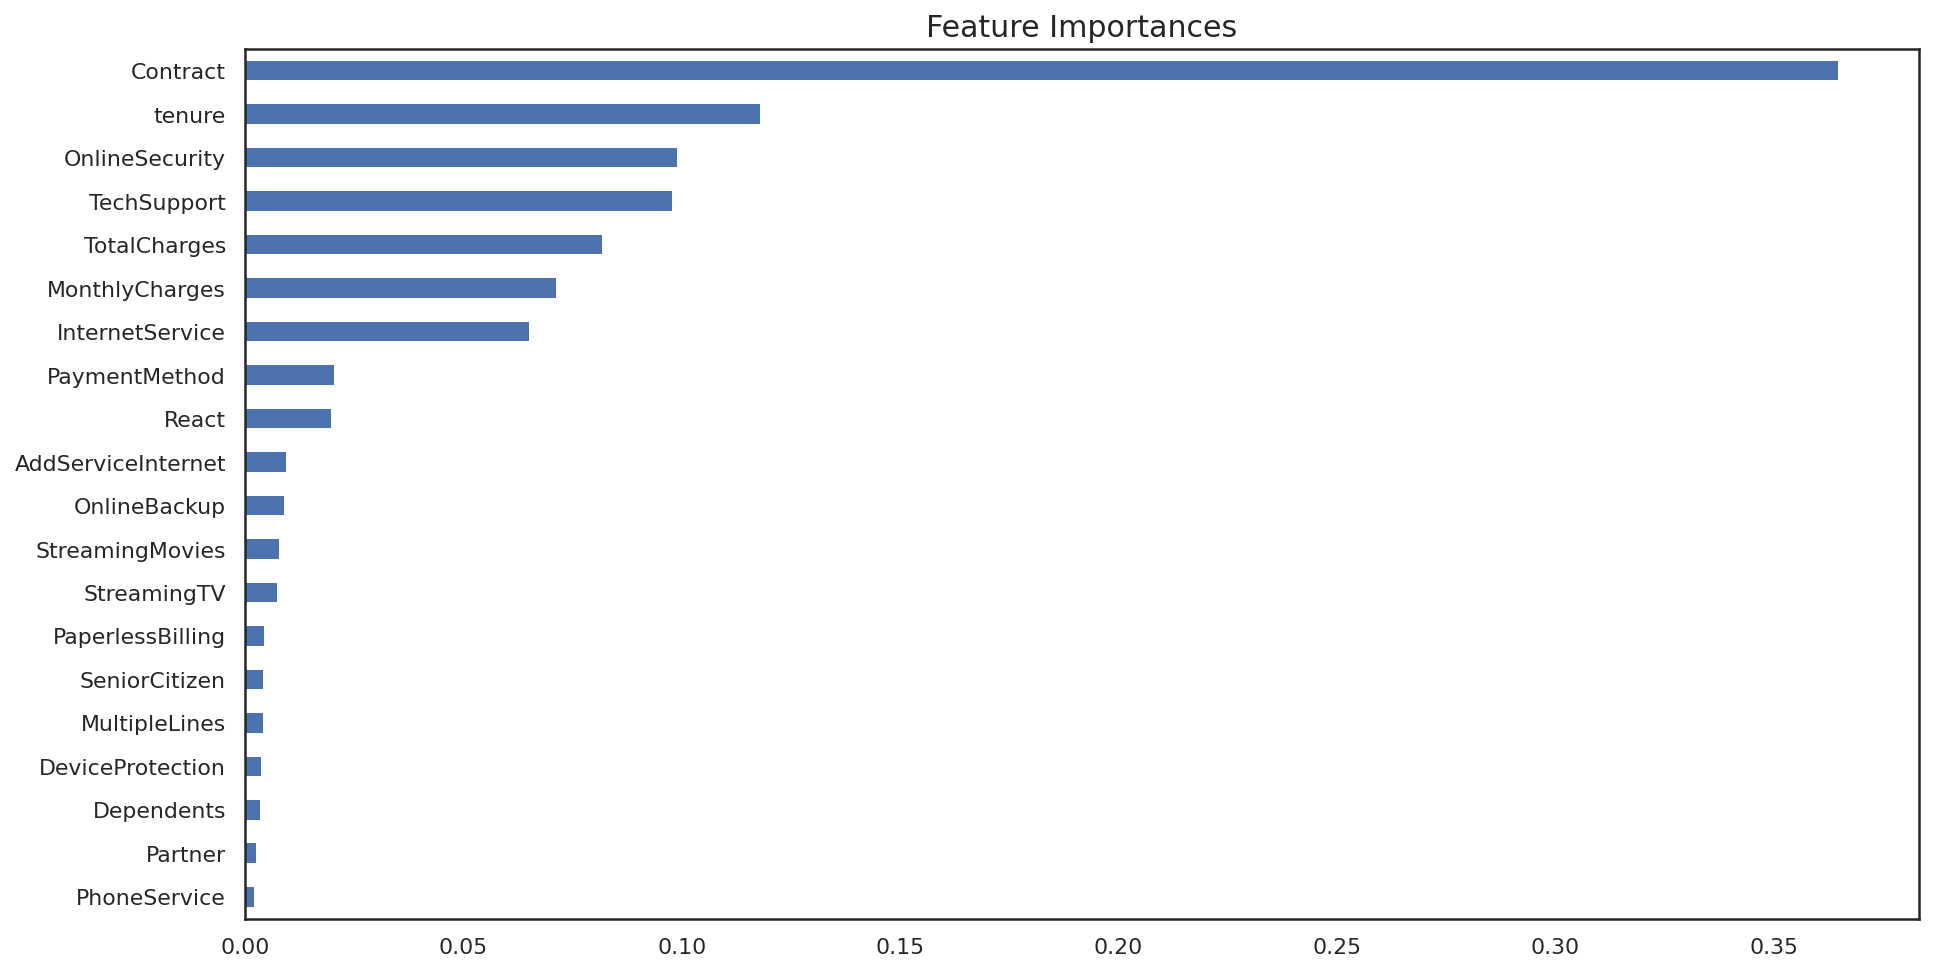

In [73]:
feature_importances = pd.Series(clf.feature_importances_, X_test.columns)

plt.figure(figsize=(15,8))
feature_importances.sort_values().plot.barh()
plt.title('Feature Importances', fontsize=15)
plt.show()

In [67]:
# 순열 중요도 계산
permuter = PermutationImportance(clf,
                                 scoring='roc_auc',
                                 n_iter=5,
                                 random_state=2)

permuter.fit(X_test_preprocessed, y_test)

PermutationImportance(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=6,
                                                       max_features=0.4893012881271256,
                                                       min_samples_leaf=3,
                                                       min_samples_split=7,
                                                       n_estimators=469,
                                                       random_state=2),
                      random_state=2, scoring='roc_auc')

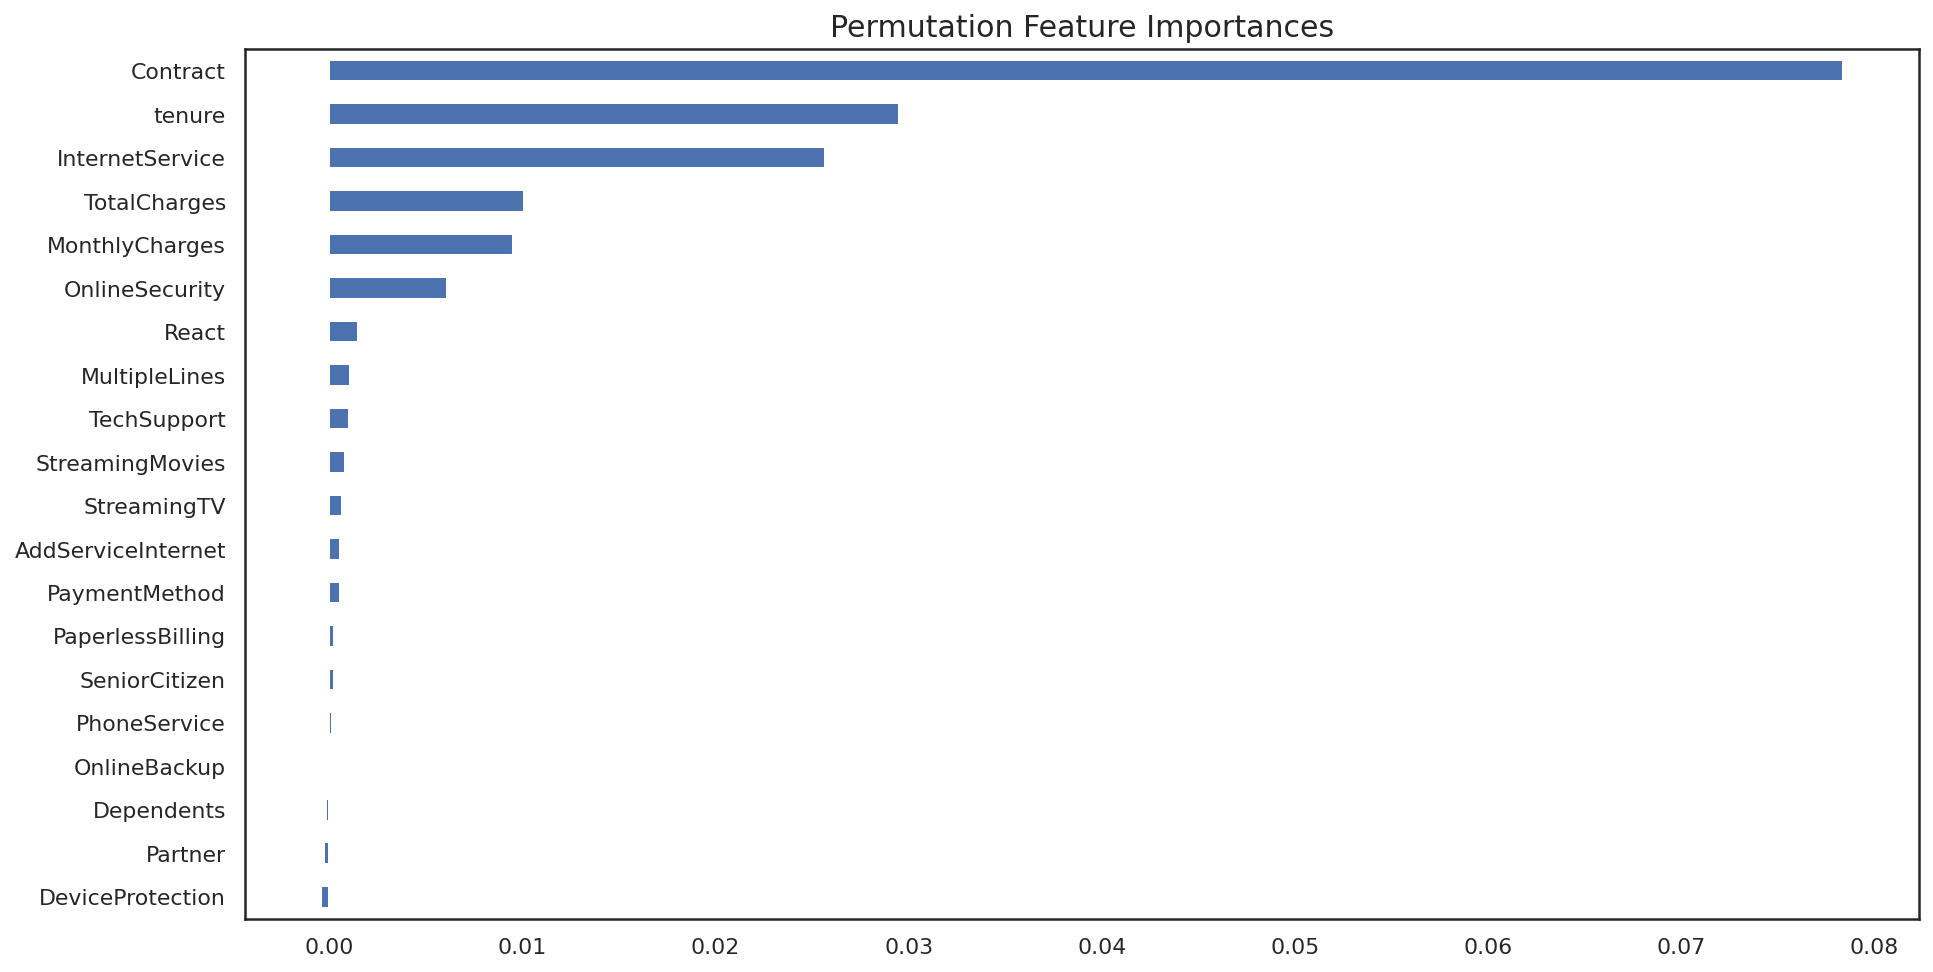

In [74]:
# 순열 중요도 확인.
plt.figure(figsize=(15,8))
features = X_test.columns.to_list()
pd.Series(permuter.feature_importances_, features).sort_values().plot.barh()
plt.title('Permutation Feature Importances', fontsize=15)
plt.show()

특성 중요도와 순열 중요도 모두 확인해본 결과 공통적으로 다음과 같은 것들이 중요한 특성으로 확인되었다.

1. 계약 유형 
2. 누적 이용 기간
3. 인터넷 서비스 가입 여부, 인터넷 부가서비스 가입 여부 (OnlineSecurity, TechSupport)
4. 지불 방법
5. 고객이 가격을 자주 확인할 수 있는 환경

다만, 시각화를 통해 중요하게 생각했던 고객이 65세 이상인지와, 부가 인터넷 서비스 가입 정도를 나타낸 AddServiceInternet의 경우 모델이 중요한 특성으로 생각하지 않는 걸 볼 수 있다.

## **가설 검정(신뢰도 95%) 및 결론**

In [ ]:
# 가설 검정 결과 print 하는 함수.
def t_test(pvalues):
  for pv, i in zip(pvalues, range(1,len(pvalues)+1)):
    if pv < 0.05:
      print(f'{i}. 대안가설 채택(p-value : {pv})')
    else:
      print(f'{i}. 귀무가설 채택(p-value : {pv})')

### **tenure**
1. **귀무가설** : 오래된 고객(중앙값 이상)의 경우 이탈률이 전체 이탈률 보다 낮지 않다. / **대안가설** : 낮다.
2. **귀무가설** : 오래되지 않은 고객의 경우(중앙값 미만) 이탈률이 전체 이탈률 보다 높지 않다. / **대안가설** : 높다.

In [ ]:
df['tenure'].describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [ ]:
long_tenure = stats.ttest_1samp(df[df['tenure'] >= 29.0]['Churn'], 0.26, alternative='less')
short_tenure = stats.ttest_1samp(df[df['tenure'] < 29.0]['Churn'], 0.26, alternative='greater')

In [ ]:
pvs = [long_tenure.pvalue, short_tenure.pvalue]
t_test(pvs)

1. 대안가설 채택(p-value : 3.039510043630722e-101)
2. 대안가설 채택(p-value : 1.1747177813966005e-61)


다 대안가설이 채택되었으므로, **오래된 고객일 수록 이탈률이 낮고**, **오래되지 않은 고객일 수록 이탈률이 높다**고 볼 수 있다.

### **Contract**

1. **귀무가설** : 2년 계약한 경우 이탈률이 전체 이탈률 보다 낮지 않다. / **대립가설** : 낮다.
2. **귀무가설** : 1년 계약한 경우 이탈률이 전체 이탈률 보다 낮지 않다. / **대립가설** : 낮다.
3. **귀무가설** : 월 단위로 계약한 경우 이탈률이 전체 이탈률 보다 높지 않다. / **대립가설** : 높다.

In [ ]:
two_year = stats.ttest_1samp(df[df['Contract'] == 'Two year']['Churn'], 0.26, alternative='less')
one_year = stats.ttest_1samp(df[df['Contract'] == 'One year']['Churn'], 0.26, alternative='less')
month = stats.ttest_1samp(df[df['Contract'] == 'Month-to-month']['Churn'], 0.26, alternative='greater')

In [ ]:
pvs = [two_year.pvalue, one_year.pvalue, month.pvalue]
t_test(pvs)

1. 대안가설 채택(p-value : 0.0)
2. 대안가설 채택(p-value : 5.6573478897358275e-65)
3. 대안가설 채택(p-value : 2.5117934087284068e-93)


다 대안가설이 채택 되었으므로, 1년 이상 계약한 경우 **이탈률은 전체 이탈률 보다 낮고**, 월 단위로 계약한 경우 **이탈률이 전체 이탈률 보다 높다**고 볼 수 있다.

### **누적 사용 기간(tenure)과 계약 단위(Contract) 가설 검정으로 알 수 있는 것.**

1. 오래된 고객일 수록 충성도가 높다.
2. 계약 단위가 1년 이상일 경우 이탈률이 낮다.

**즉, 계약 단위를 1년 이상으로 했을때 사은품이나 혜택을 주는 이벤트로 미래에 충성도가 높을 고객을 확보할 수 있다.**

### **MonthlyCharges**

1. **귀무가설** : 월 납부 요금이 평균 월 납부 요금 이상인 경우 이탈률이 전체 이탈률 보다 높지 않다. / **대안가설** : 높다.
2. **귀무가설**  월 납부 요금이 평균 월 납부 요금 미만인 경우 이탈률이 전체 이탈률 보다 낮지 않다. / **대안가설** : 낮다.

In [ ]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

In [ ]:
month_mean = df['MonthlyCharges'].mean()
low_charge = stats.ttest_1samp(df[df['MonthlyCharges'] >= month_mean]['Churn'], 0.26, alternative='greater')
high_charge = stats.ttest_1samp(df[df['MonthlyCharges'] < month_mean]['Churn'], 0.26, alternative='less')

In [ ]:
pvs = [low_charge.pvalue, high_charge.pvalue]
t_test(pvs)

1. 대안가설 채택(p-value : 2.667501367237675e-29)
2. 대안가설 채택(p-value : 7.02475362620671e-45)


다 대안가설이 채택 되었으므로, 월 요금이 평균 요금보다 높은 경우 **이탈률은 전체 이탈률 보다 높고**, 월 요금이 평균 요금보다 낮은 경우 **이탈률은 전체 이탈률 보다 낮다**고 볼 수 있다.

### **React**

1. **귀무가설** : 전자 명세서와 전자 결제를 둘다 사용하더라도 (가격을 자주 접하는 환경) 이탈률이 전체 이탈률 보다 높지 않다. / **대안가설** : 높다.
2. **귀무가설** : 전자 명세서와 전자 결제를 둘중 하나만 사용하는 경우 이탈률이 전체 이탈률 보다 높지 않다. / **대안가설** : 높다.
3. **귀무가설** : 전자 명세서와 전자 결제를 둘다 사용하지 않는 경우 이탈률이 전체 이탈률 보다 낮지 않다.(아무 연관이 없을 것이다.) / **대안가설** : 낮다.

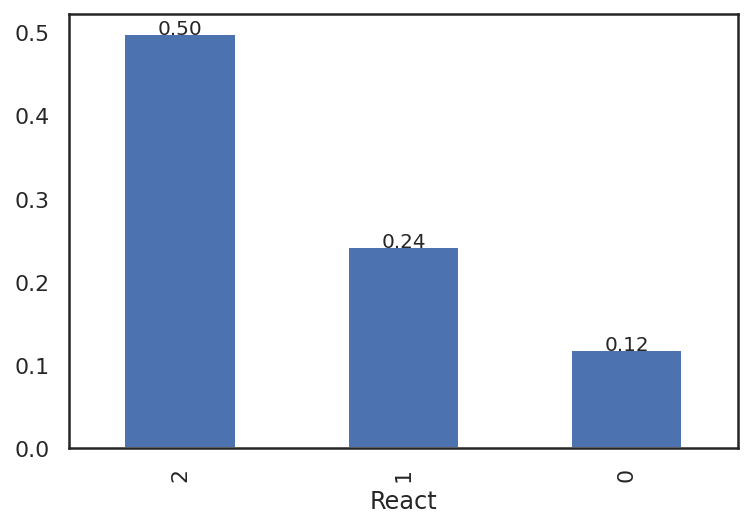

In [ ]:
barplot_churnratio('React')

In [ ]:
react_2 = stats.ttest_1samp(df[df['React'] == 2]['Churn'], 0.26, alternative='greater')
react_1 = stats.ttest_1samp(df[df['React'] == 1]['Churn'], 0.26, alternative='greater')
react_0 = stats.ttest_1samp(df[df['React'] == 0]['Churn'], 0.26, alternative='less')

In [ ]:
pvs = [react_2.pvalue, react_1.pvalue, react_0.pvalue]
t_test(pvs)

1. 대안가설 채택(p-value : 2.0431177816863663e-79)
2. 귀무가설 채택(p-value : 0.9907686744539083)
3. 대안가설 채택(p-value : 4.0150101990160306e-88)


전자 명세서와 전자 결제를 **둘다 사용하는 경우 이탈률이 더 높았고** 둘 중 **하나만 사용하는 경우에 이탈률이 더 크지는 않았다.** 마지막으로 둘 중 **아무것도 사용하지 않는 경우에는 이탈률이 전체 이탈률 보다 더 낮았다.**

### **월 납부 금액(MonthlyCharges)와 가격을 자주 접할 수 있는 환경(React) 가설 검정으로 알 수 있는 것.**

**월 납부 금액이 높을 수록 고객이 이탈할 확률이 높고 납부 금액을 더 자주 접할 수록 이탈할 확률이 높아진다.**

### **InternetService**

1. **귀무가설** : Fiber optic (더 좋은 인터넷 서비스)를 이용하는 경우 이탈률이 전체 이탈률 보다 높지 않다. / **대안가설** : 높다
2. **귀무가설** : DSL (더 낮은 사양의 인터넷)을 이용하는 경우 이탈률이 전체 이탈률 보다 더 낮지 않다. / **대안가설** : 낮다

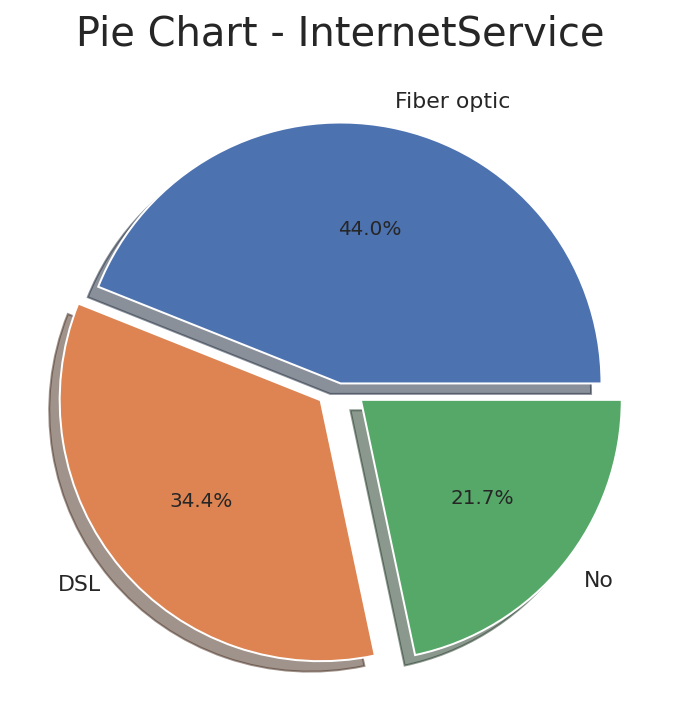

In [ ]:
pieplot('InternetService')

In [ ]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [ ]:
fiber = stats.ttest_1samp(df[df['InternetService'] == 'Fiber optic']['Churn'], 0.26, alternative='greater')
dsl = stats.ttest_1samp(df[df['InternetService'] == 'DSL']['Churn'], 0.26, alternative='less')

In [ ]:
pvs = [fiber.pvalue, dsl.pvalue]
t_test(pvs)

1. 대안가설 채택(p-value : 1.0450673290919747e-68)
2. 대안가설 채택(p-value : 1.6370946626475992e-18)


Fiber optic 인터넷을 사용하는 경우 **이탈률이 전체 이탈률보다 더 높고**, DSL 서비스를 사용하는 경우 **이탈률이 전체 이탈률 보다 더 낮다.**

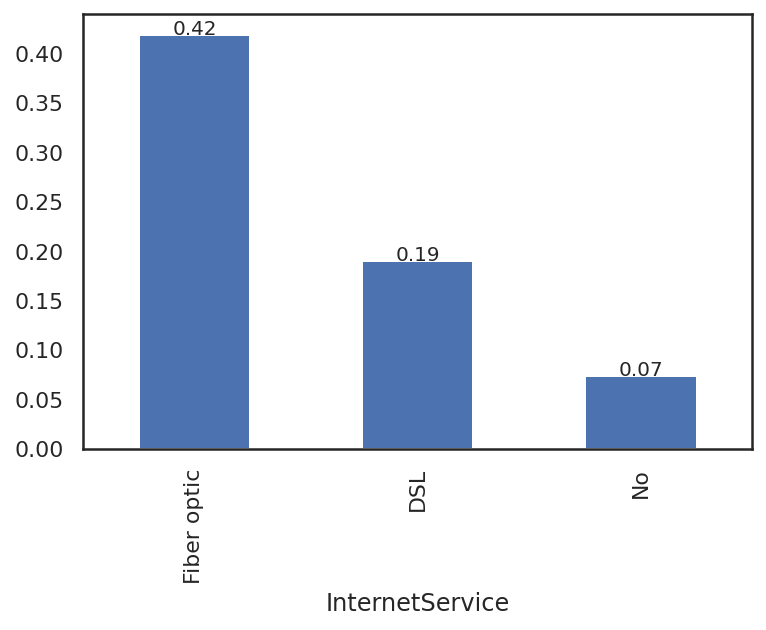

In [ ]:
barplot_churnratio('InternetService')

Fiber optic을 사용하는 고객이 총 고객 중 42%로 가장 많은 비중을 차지하는데 이탈률도 약 42%로 가장 높다. 가격대비 서비스가 부족하거나, 경쟁사 대비 가겨이 너무 비싸서 문제일 수도 있다. 하지만 Fiber optic **바이올린 플랏**을 보면 전체적인 월 요금이 높긴 하지만, **월 요금이 60~80달러대인 고객보다 100달러 근처인 고객의 이탈이 더 적었다.** 즉, 가격의 문제도 있지만 **서비스 질의 문제일 확률이 더 높을 수 있다.**

### **SeniorCitizen**
1. 귀무가설 : 65세 이상일 경우 이탈률이 전체 이탈률 보다 높지 않다. / 대안가설 : 높다.
2. 귀무가설 : 65세 미만일 경우 이탈률이 전체 이탈률 보다 낮지 않다. / 대안가설 : 낮다.

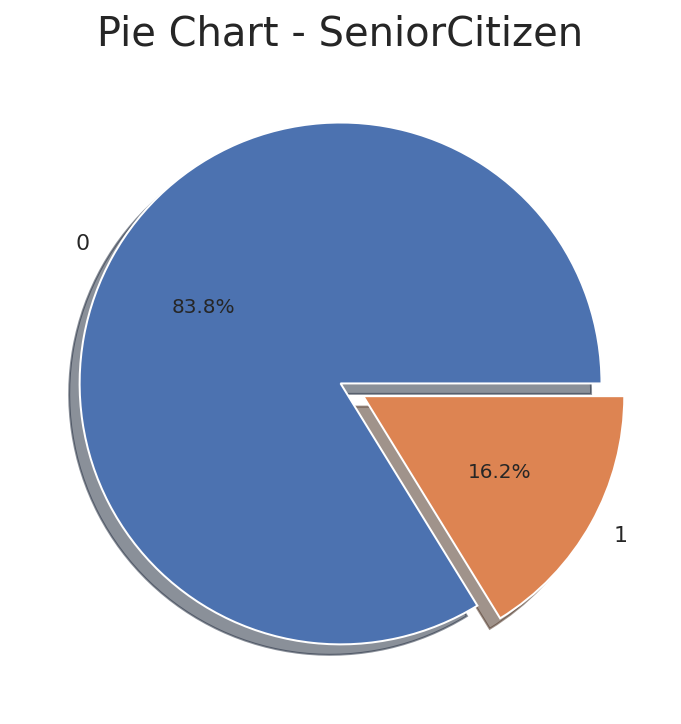

In [ ]:
pieplot('SeniorCitizen')

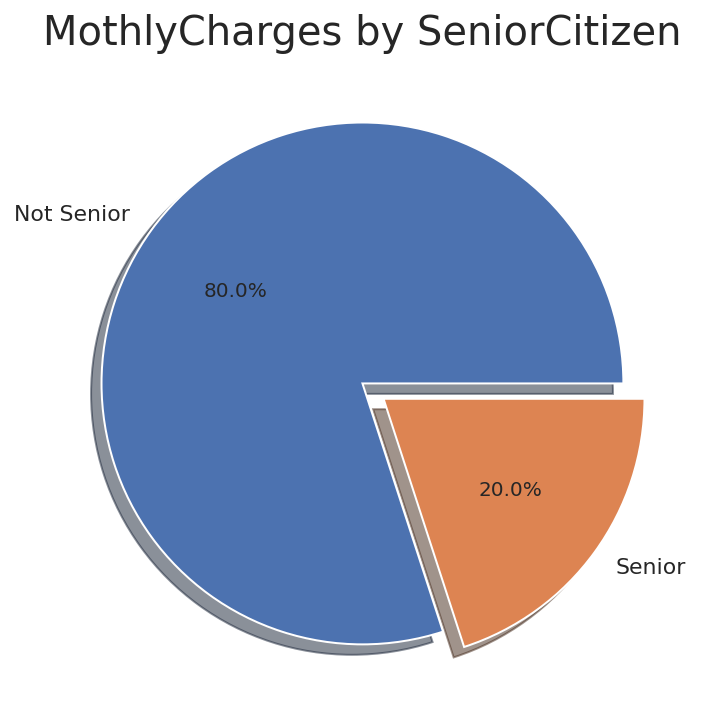

In [ ]:
senior_gp = df.groupby('SeniorCitizen')[['MonthlyCharges']].sum()
senior_gp['Charges_ratio'] = senior_gp['MonthlyCharges']/senior_gp['MonthlyCharges'].sum()
labels = ['Not Senior', 'Senior']

plt.figure(figsize=(10,6))
plt.title('MothlyCharges by SeniorCitizen', fontsize=20)
plt.pie('Charges_ratio', data= senior_gp, labels=labels, explode=[0,0.1] ,shadow=True, autopct='%.1f%%')
plt.show()

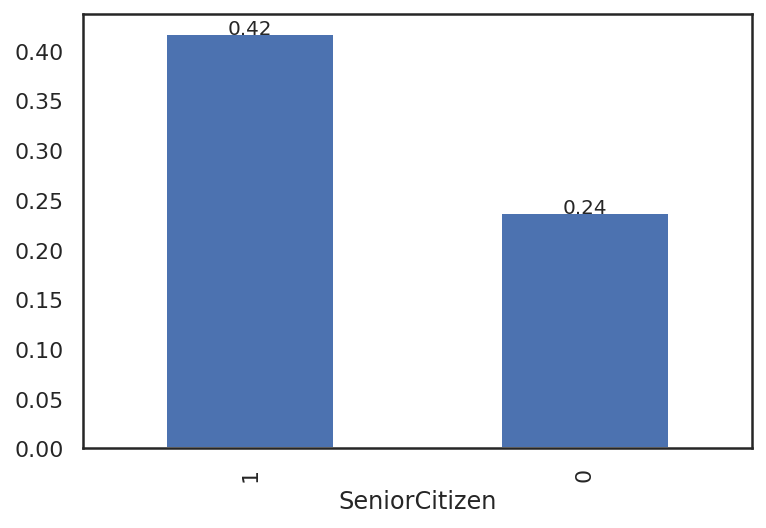

In [ ]:
barplot_churnratio('SeniorCitizen')

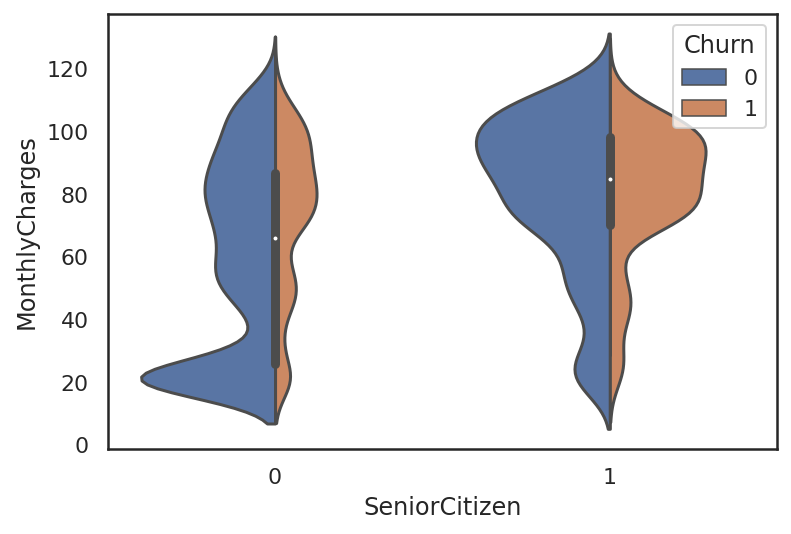

In [ ]:
sns.violinplot('SeniorCitizen', 'MonthlyCharges', hue='Churn', data=df, scale='count', split=True);

In [ ]:
senior = stats.ttest_1samp(df[df['SeniorCitizen'] == 1]['Churn'], 0.26, alternative='greater')
not_senior = stats.ttest_1samp(df[df['SeniorCitizen'] == 0]['Churn'], 0.26, alternative='less')

In [ ]:
pvs = [senior.pvalue, not_senior.pvalue]
t_test(pvs)

1. 대안가설 채택(p-value : 5.140739907805168e-26)
2. 대안가설 채택(p-value : 1.117403991998201e-05)


가설 검정을 통해 65세 이상 고객이 이탈률이 **전체 이탈률이 보다 높고**, 65세 미만 고객의 경우 이탈률이 **전체 이탈률 보다 낮다**는 걸 확인했다.

65세 이상 고객의 비중은 16%로 낮은 편이지만 이탈률은 약 42%로 상당히 높고 월 납부 요금 중 총 20%의 비중을 차지하기에 무시하기는 힘든 비중이라고 생각.

월 납부 금액 분포는 65세 미만에 비해 **높은 쪽에 분포**해있고, 80~100달러 부근에서 많은 이탈이 이루어진다. 고령층의 이탈을 막기 위해 **고령층을 겨냥한 특가 상품등의 전략을 생각해 볼 수 있을 것 같다.**

### **Partner, Dependents**

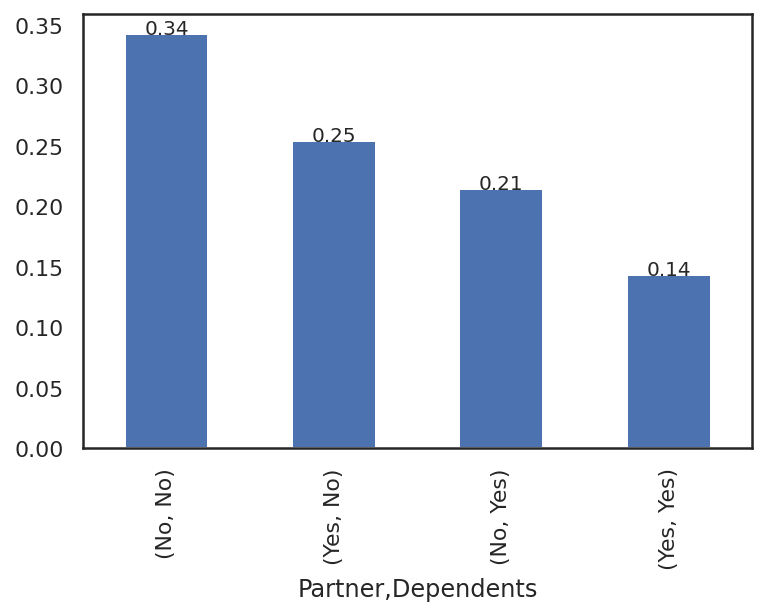

In [ ]:
barplot_churnratio(['Partner', 'Dependents'])

결혼도 했고 부양 가족도 있는 경우 **이탈률이 낮은 걸 볼 수 있다.** 둘다 아닌 경우 즉, 혼자 사는 경우에는 **이탈률이 전체 이탈률 보다 높다.** 그래프를 보면 파트너가 없거나 부양 가족이 없는 경우 **이탈률이 서서히 올라가긴 하지만 전체 이탈률에 못 미치는 걸 볼 수 있다.** 이러한 이유로 모델에서는 중요하지 않은 특성이라고 판단했을 것 같다.

### **AddServiceInternet**

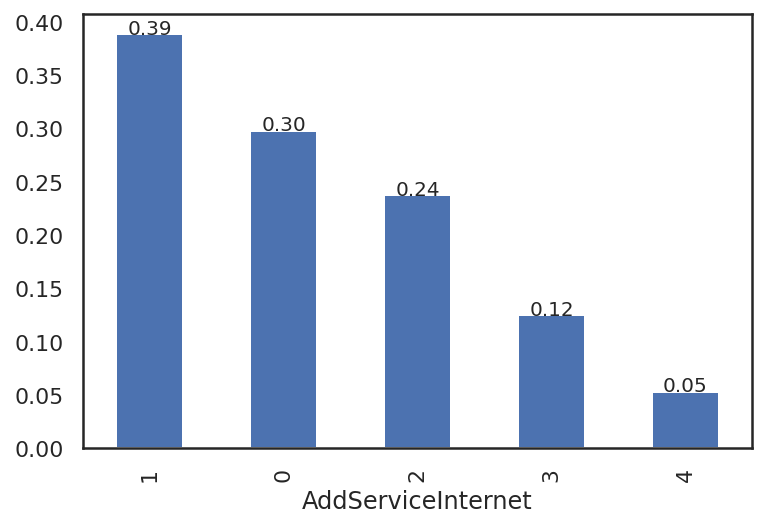

In [ ]:
barplot_churnratio('AddServiceInternet')

인터넷 부가 서비스의 경우 2개 이하로 가입했을때는 1개 가입한 경우가 오히려 하나도 가입하지 않은 경우에 비해 이탈률이 더 높기도 하고 큰 의미가 없지만, **3개 이상부터는 이탈률에 영향을 끼치는 것을 보인다.**

따라서 **더 많은 인터넷 부가 서비스 가입을 위한 유인 정책이 있다면 고객의 이탈을 방지**할 수 있다.

<br>

## ***이탈 방지를 위해 생각해 볼 수 있는 전략***

1. 계약 단위를 1년 이상으로 했을때 사은품이나 혜택을 주는 이벤트로 미래에 충성도가 높을 고객을 확보

2. Fiber Optic 인터넷 서비스 가격대비 서비스 질 향상

3. 자동결제 시스템을 이용할 경우 가격에 둔감하게 반응했기에, 결제 시스템을 자동결제 시스템으로 통일하는 방안

4. 고령층을 겨냥한 특가 상품등을 기획하여 고령층의 높은 이탈률을 낮춘다.

5. 더 많은 인터넷 부가 서비스 가입을 위한 유인 정책